In [1]:
%cd ../..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/jeffrey-uso9-03-dev-ci01/code/Users/jeffrey.tackes/ModernTS_2E


In [2]:
import os
import shutil
import json

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.auto import AutoNHITS
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mse, mase
from functools import partial

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

/tmp/ipykernel_168513/1934273446.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-08-12 16:44:16,279	WARNING __init__.py:21 -- Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.
/anaconda/envs/demand_planning/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
TRAIN_SUBSAMPLE = False  # Trains a subsample of IDs to improve run speed
RETUNE = True  # if false, will use pre-trained hyperparameters when generating the AUTO NeuralForecast

In [4]:
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [5]:
train_df.head(2)

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000061               0.114     30min          37872   
1 2012-01-01 00:30:00  MAC000061               0.113     30min          37872   

  stdorToU    Acorn Acorn_grouped      file    holidays  ...  \
0      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   
1      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   

   timestamp_Minute_sin_1  timestamp_Minute_sin_2  timestamp_Minute_sin_3  \
0            0.000000e+00            0.000000e+00            0.000000e+00   
1            5.665539e-16           -1.133108e-15            2.143751e-15   

   timestamp_Minute_sin_4  timestamp_Minute_sin_5  timestamp_Minute_cos_1  \
0            0.000000e+00            0.000000e+00                     1.0   
1           -2.266215e-15            6.123234e-16                    -1.0   

   timestamp_Minute_cos_2 timestamp_Minute_cos_3 timestamp_Minute_cos_4  \
0                     1.0                    1.0                    1.0   
1                     1.0                   -1.0                    1.0   

   timestamp_Minute_cos_5  
0                     1.0  
1                    -1.0  

[2 rows x 94 columns]

In [6]:
print("Total # of IDs Pre-Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Pre-Sampling:  150


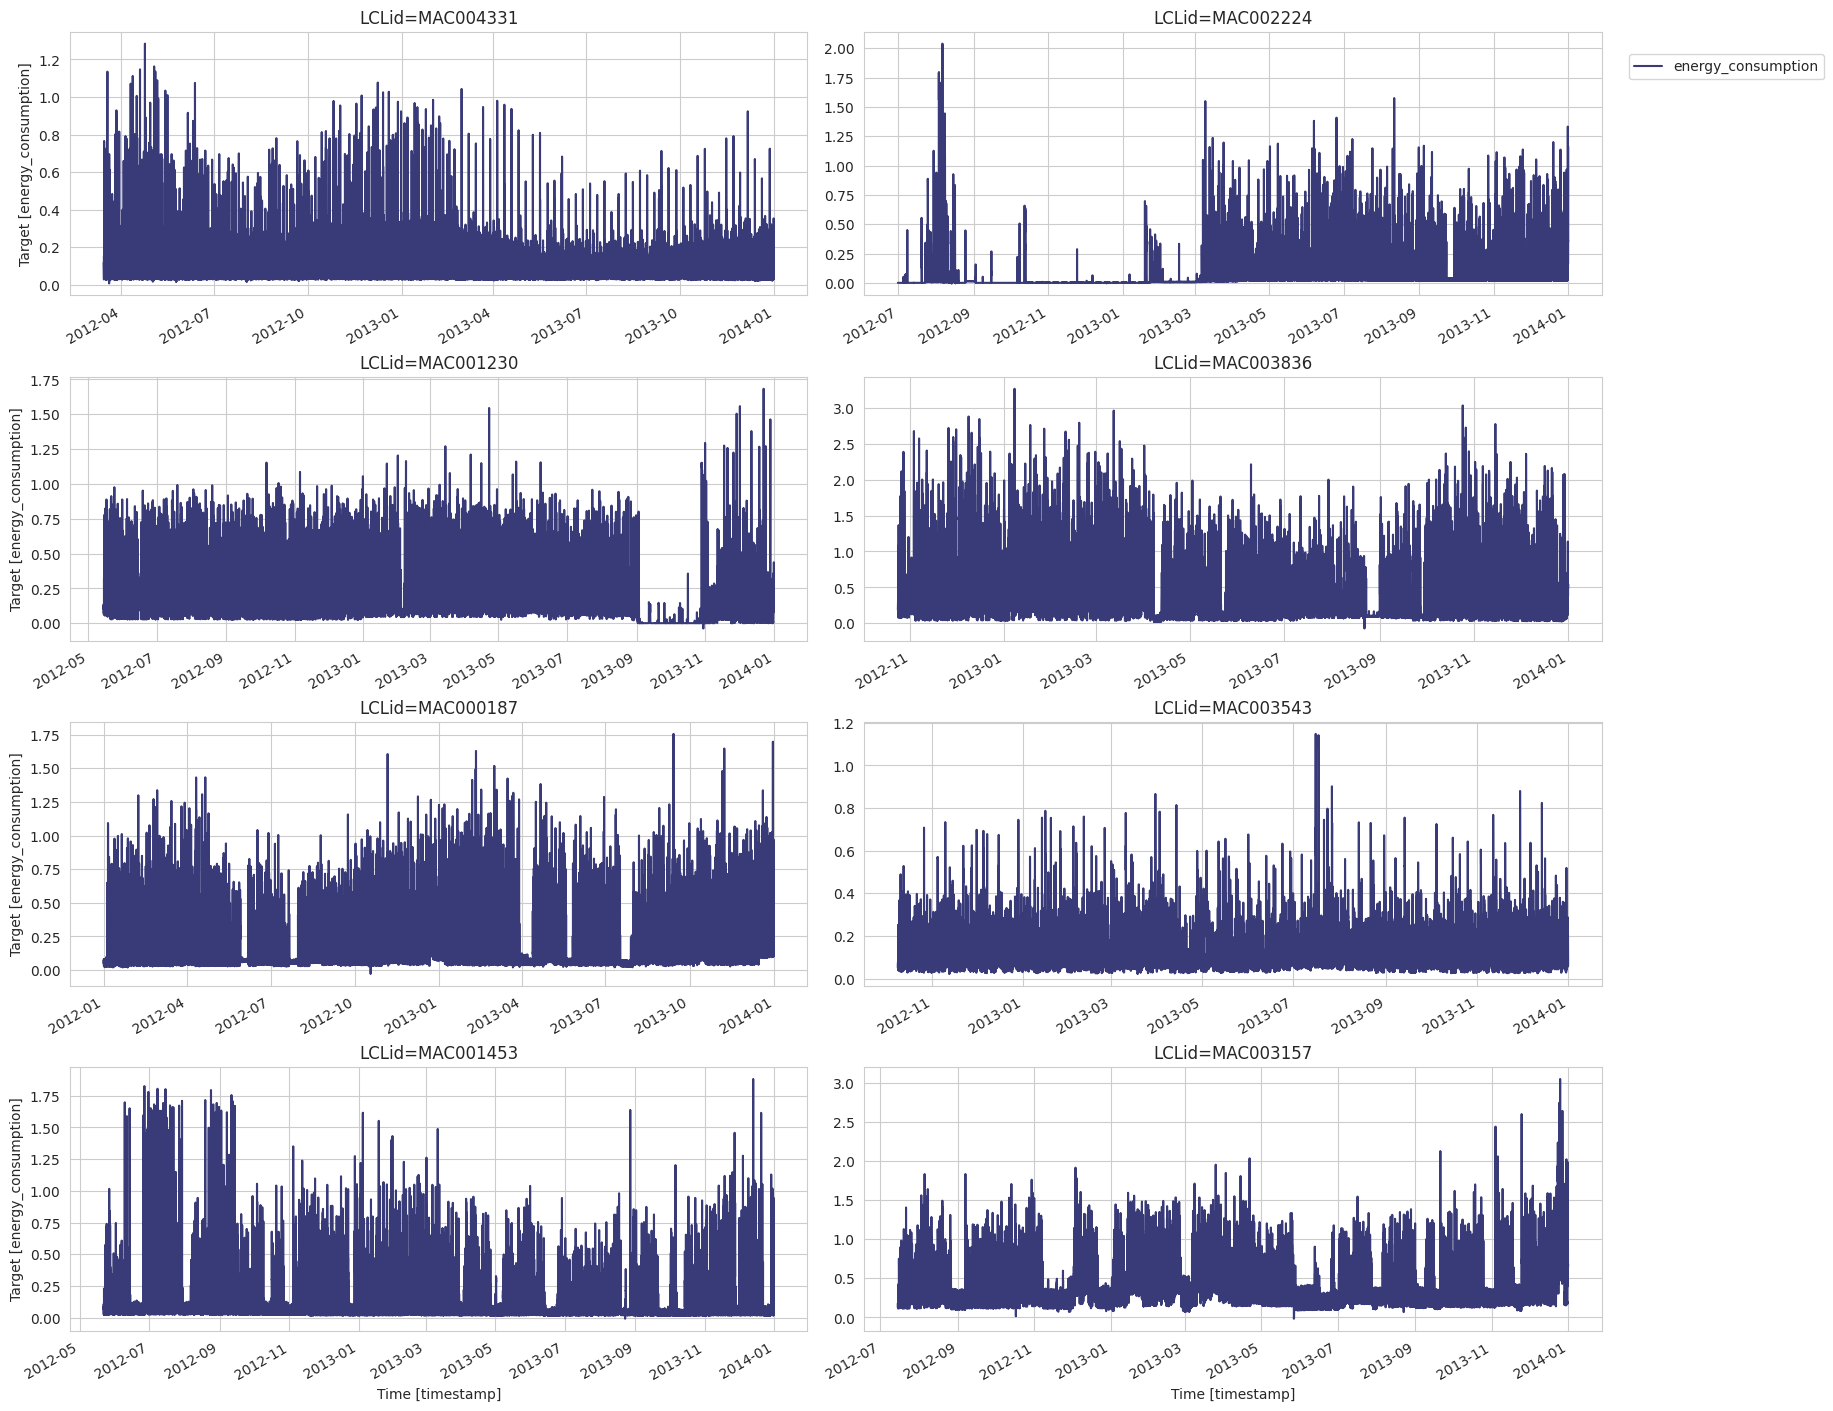

In [7]:
StatsForecast.plot(train_df, engine='matplotlib', id_col='LCLid',time_col= 'timestamp', target_col='energy_consumption')

In [8]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    print("sub sampling")
    SAMPLE = 10
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

In [9]:
print("Total # of IDs Post Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Post Sampling:  150


## Train, Validation, Test Set

In [10]:
print("Training Min Date: ", train_df.timestamp.min(), 
      "\nTraining Max Date: ", train_df.timestamp.max(), 
      "\nTesting Min Date: ", test_df.timestamp.min(),
      "\nTesting Max Date: ", test_df.timestamp.max()
)

Training Min Date:  2012-01-01 00:00:00 
Training Max Date:  2013-12-31 23:30:00 
Testing Min Date:  2014-01-01 00:00:00 
Testing Max Date:  2014-01-31 23:30:00


In [11]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")

validation_df = train_df[(train_df.timestamp>cutoff)].reset_index(drop=True) # validation prediction set
training_df = train_df[(train_df.timestamp<=cutoff)].reset_index(drop=True) # training set used for validation set

print(f"Train Max: {training_df.timestamp.max()} \nValidation Min: {validation_df.timestamp.min()} \nValidation Max: {validation_df.timestamp.max()}")
print(f"Validation Horizon: {len(validation_df.timestamp.unique())}")


Train Max: 2013-12-30 23:30:00 
Validation Min: 2013-12-31 00:00:00 
Validation Max: 2013-12-31 23:30:00
Validation Horizon: 48


##### Define Validation model parameters

In [12]:
h = 48
max_steps = 100

## Training NHITS Model

In [13]:
model_untuned = [NHITS(h=h,  input_size = 48*7,              
                max_steps=max_steps)]

model_untuned = NeuralForecast(models=model_untuned, freq='30min')
model_untuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.3 M 
-----------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.079    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [14]:
# Get Predictions for validation
pred_df =  model_untuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df.merge(validation_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp     NHITS  energy_consumption
0  MAC000061 2013-12-31 00:00:00  0.110659               0.053
1  MAC000061 2013-12-31 00:30:00  0.096543               0.053
2  MAC000061 2013-12-31 01:00:00  0.080454               0.048
3  MAC000061 2013-12-31 01:30:00  0.071152               0.050
4  MAC000061 2013-12-31 02:00:00  0.060134               0.050

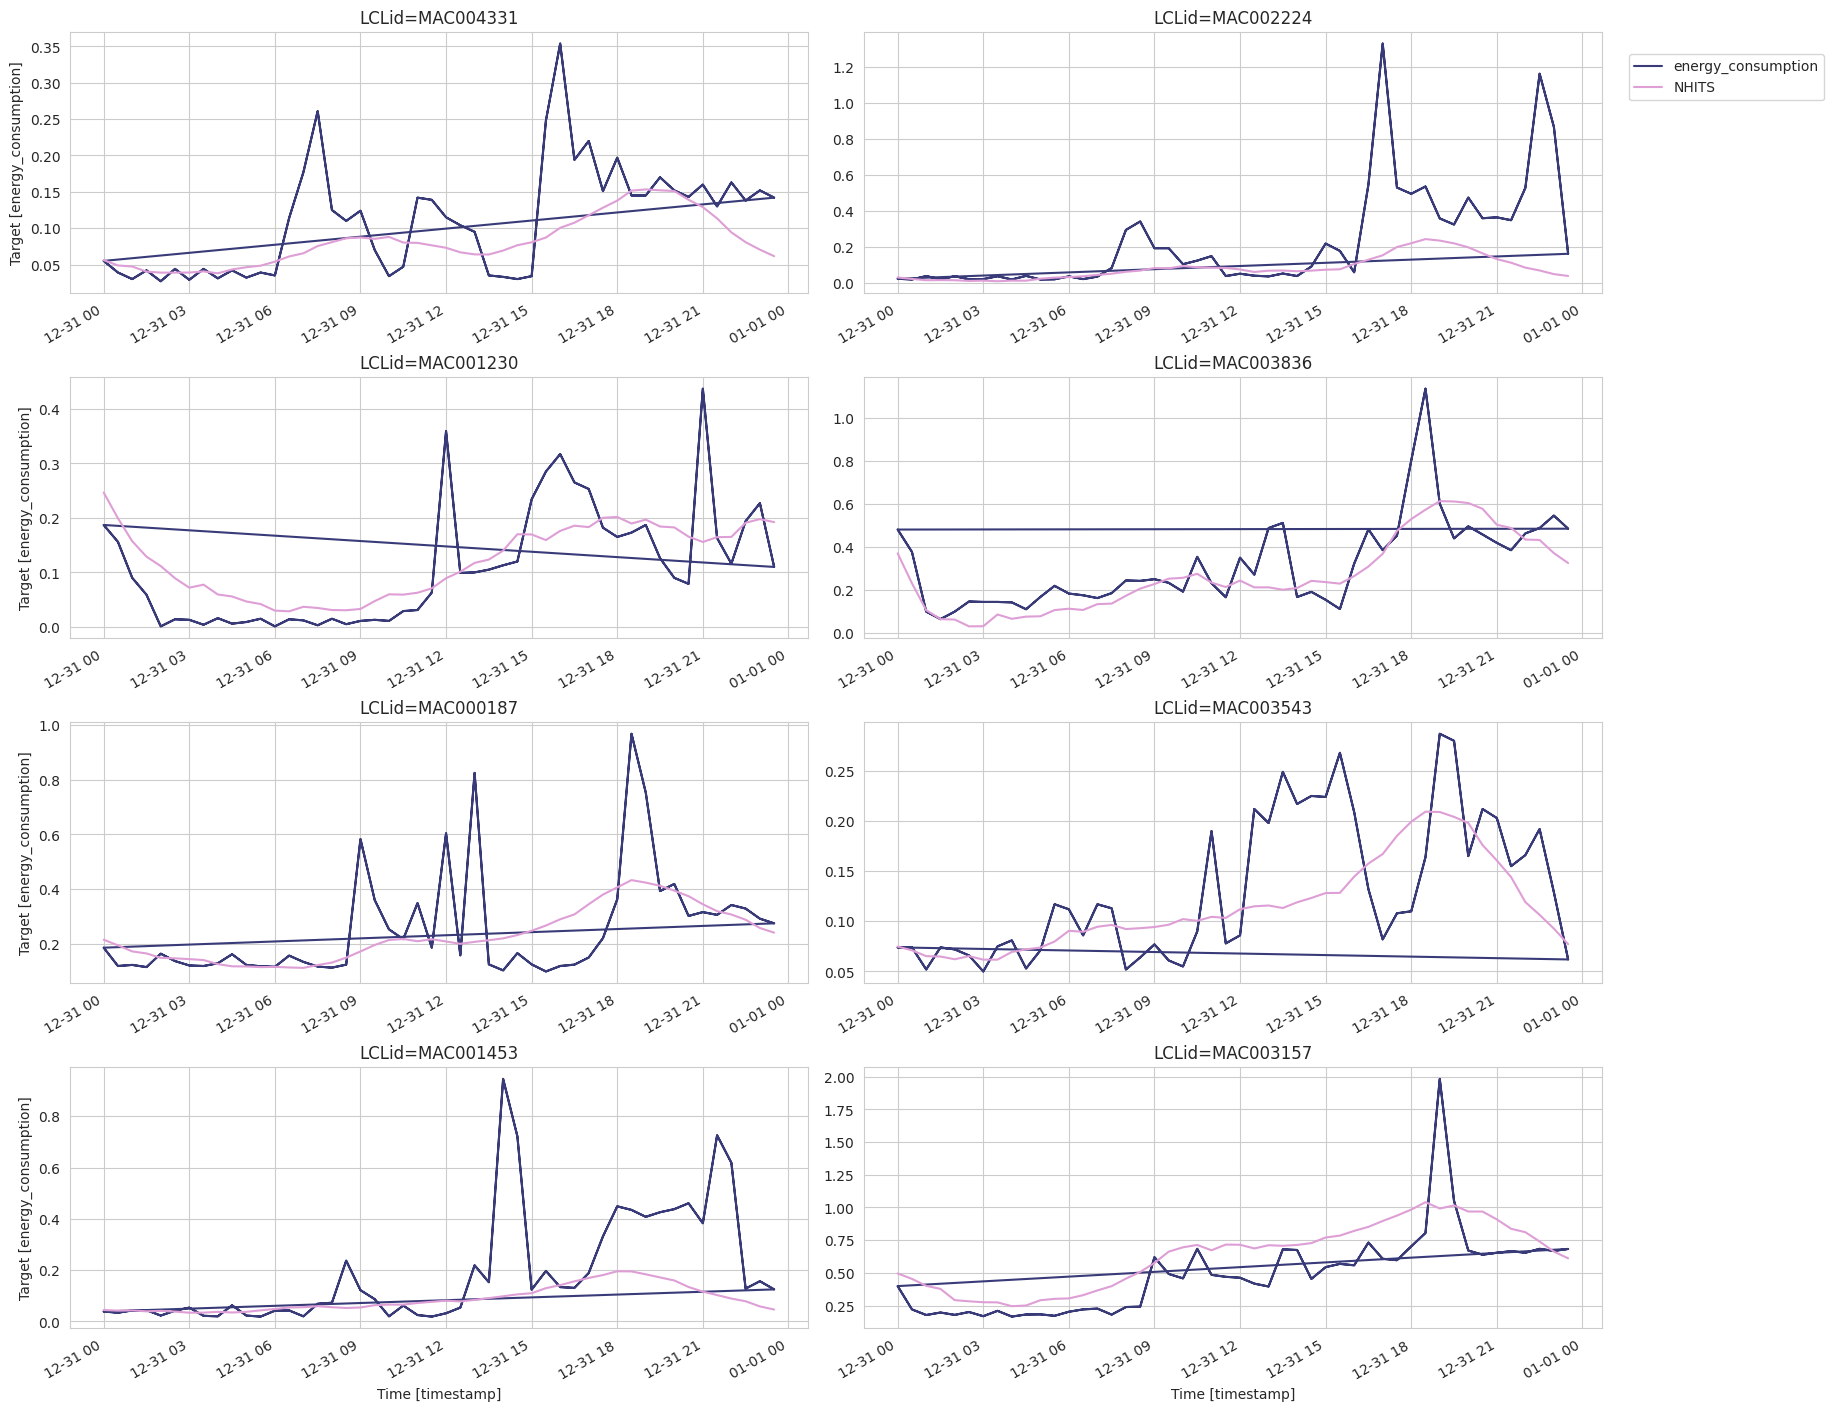

In [15]:
#visualize results
StatsForecast.plot(validation_df[['LCLid','timestamp','energy_consumption']], 
                   pred_df, engine='matplotlib', 
                   id_col='LCLid',
                   time_col= 'timestamp', 
                   target_col='energy_consumption',
                   models=['NHITS'])

#### Evaluate NHITS forecast

In [16]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
NHITS_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
NHITS_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [17]:
NHITS_metrics_agg

metric     NHITS
0   rmse  0.158511
1    mae  0.100556
2    mse  0.046867
3   mase  0.923954

## NHITS Tuned
Since hyperparameters are key to performance in Neural Networks, NIXTLA has made this search each through the incorporation of Auto forecast.
Each NeuralForecast model has an AUTO class which allow you to easily tune your hyperparameters.

Auto Forecast can time, you can load the pre-trained hyperparameters or choose to retune on your own.
Set ```RETUNE = True``` if you wish to retune.


In [18]:
# Define the file path
config_file_path = 'notebooks/Chapter16/saved_params_config/NHITS_best_config.json'
try:
    with open(config_file_path, 'r') as config_file:
        loaded_config = json.load(config_file)
        print(loaded_config)
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. 
    </div>
    """))
    

In [19]:
NHITS_config = {
    "max_steps": max_steps,  # This parameter can be adjusted if needed
    #"input_size": 48*7*2,  # Size of input window
    "input_size": tune.choice([h,h*7,h*7*2,h*7*3]),
    "learning_rate": tune.loguniform(1e-2, 1e-1),  # Initial learning rate
    "scaler_type": tune.choice(["minmax", "robust", "standard"]),
    #"dropout_prob_theta":tune.uniform(0, .1),
    "batch_size": tune.choice([32, 64])    
}

if RETUNE == True:
    models = [AutoNHITS(h=h, 
                     config = NHITS_config,
                     search_alg = HyperOptSearch(),
                     backend = 'ray',
                     num_samples = 100,
                     cpus=1)]

else:
    models = [AutoNHITS(h=h, 
                    config = loaded_config,
                    search_alg = None,
                    backend = 'ray',
                    cpus=1)]


model_tuned = NeuralForecast(models=models, freq='30min')
model_tuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption', verbose = True)

(_train_tune pid=172711) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=172711) Seed set to 1
(_train_tune pid=172711) GPU available: False, used: False
(_train_tune pid=172711) TPU available: False, using: 0 TPU cores
(_train_tune pid=172711) IPU available: False, using: 0 IPUs
(_train_tune pid=172711) HPU available: False, using: 0 HPUs
(_train_tune pid=172711) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_914f33f2_1_batch_size=32,h=48,input_size=1008,learning_rate=0.0178,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-45-10/lightning_logs
(_train_tune pid=172711) 
(_train_tune pid=172711)   | Name         | Type          | Params
(_train_tune pid=172711) --------------------------------

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=172880) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=172880) Seed set to 1


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/3 [00:00<?, ?it/s]


(_train_tune pid=173062) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=173062) Seed set to 1
(_train_tune pid=172880) GPU available: False, used: False
(_train_tune pid=172880) TPU available: False, using: 0 TPU cores
(_train_tune pid=172880) IPU available: False, using: 0 IPUs
(_train_tune pid=172880) HPU available: False, using: 0 HPUs
(_train_tune pid=172880) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_ee4a8392_2_batch_size=64,h=48,input_size=48,learning_rate=0.0126,loss=ref_ph_de895953,max_steps=100,scaler_type=standa_2024-08-12_16-45-13/lightning_logs
(_train_tune pid=172880) 
(_train_tune pid=172880)   | Name         | Type          | Params
(_train_tune pid=172880) --------------------------------

Epoch 0:  20%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 1/5 [00:14<00:57,  0.07it/s, v_num=0, train_loss_step=3.510]


(_train_tune pid=173772) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=173772) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=173595) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=173595) GPU available: False, used: False
(_train_tune pid=173595) TPU available: False, using: 0 TPU cores
(_train_tune pid=173595) IPU available: False, using: 0 IPUs
(_train_tune pid=173595) HPU available: False, using: 0 HPUs
(_train_tune pid=173595) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_49b56408_4_batch_size=32,h=48,input_size=672,learning_rate=0.0724,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-45-22/light

Training: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/? [00:00<?, ?it/s]


(_train_tune pid=174197) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=174197) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=173984) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=173984) GPU available: False, used: False
(_train_tune pid=173984) TPU available: False, using: 0 TPU cores
(_train_tune pid=173984) IPU available: False, using: 0 IPUs
(_train_tune pid=173984) HPU available: False, using: 0 HPUs
(_train_tune pid=173984) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_51d1e615_6_batch_size=32,h=48,input_size=1008,learning_rate=0.0331,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-45-30/light

Epoch 0:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                 | 3/5 [00:24<00:16,  0.12it/s, v_num=0, train_loss_step=643.0] 

(_train_tune pid=174413) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=174413) Seed set to 1
(_train_tune pid=174413) ----------------------------------------------- [repeated 4x across cluster]


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.41it/s]


(_train_tune pid=174620) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=174620) Seed set to 1
(_train_tune pid=174413) GPU available: False, used: False
(_train_tune pid=174413) TPU available: False, using: 0 TPU cores
(_train_tune pid=174413) IPU available: False, using: 0 IPUs
(_train_tune pid=174413) HPU available: False, using: 0 HPUs
(_train_tune pid=174413) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_07b2f91e_8_batch_size=32,h=48,input_size=1008,learning_rate=0.0174,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-45-37/lightning_logs
(_train_tune pid=174413) 
(_train_tune pid=174413)   | Name         | Type          | Params
(_train_tune pid=174413) 0 | loss         | MAE          

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=174620) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=174837) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=174837) Seed set to 1
(_train_tune pid=174837) GPU available: False, used: False
(_train_tune pid=174837) TPU available: False, using: 0 TPU cores
(_train_tune pid=174837) IPU available: False, using: 0 IPUs
(_train_tune pid=174837) HPU available: False, using: 0 HPUs


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=7.05e+9, train_loss_epoch=2.1e+11] 

(_train_tune pid=175041) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=175041) Seed set to 1
(_train_tune pid=174837) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_7fba1ebe_10_batch_size=64,h=48,input_size=336,learning_rate=0.0266,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-45-46/lightning_logs
(_train_tune pid=174837) 
(_train_tune pid=174837)   | Name         | Type          | Params
(_train_tune pid=174837) 0 | loss         | MAE           | 0     
(_train_tune pid=174837) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=174837) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=174837) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=174837) 3.3 M     T

Epoch 8:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:01<00:02,  0.76it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=0.926] 

(_train_tune pid=175041) GPU available: False, used: False
(_train_tune pid=175041) TPU available: False, using: 0 TPU cores
(_train_tune pid=175041) IPU available: False, using: 0 IPUs
(_train_tune pid=175041) HPU available: False, using: 0 HPUs
(_train_tune pid=175041) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_56e7c957_11_batch_size=32,h=48,input_size=48,learning_rate=0.0197,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-45-50/lightning_logs
(_train_tune pid=175041) 
(_train_tune pid=175041)   | Name         | Type          | Params
(_train_tune pid=175041) 0 | loss         | MAE           | 0     
(_train_tune pid=175041) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175041) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175041) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=175041) 2.5 M     Trainable params
(_train_tune pid=175041) 0         Non-trainable params
(_train_tu

Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.935, train_loss_epoch=0.996] 

(_train_tune pid=175258) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=175258) Seed set to 1


Epoch 9:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                           | 2/3 [00:02<00:01,  0.72it/s, v_num=0, train_loss_step=0.874, train_loss_epoch=0.996] 

(_train_tune pid=175258) GPU available: False, used: False
(_train_tune pid=175258) TPU available: False, using: 0 TPU cores
(_train_tune pid=175258) IPU available: False, using: 0 IPUs
(_train_tune pid=175258) HPU available: False, using: 0 HPUs


Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=102.0, train_loss_epoch=552.0] 

(_train_tune pid=175495) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=175495) Seed set to 1
(_train_tune pid=175258) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_3fa55117_12_batch_size=32,h=48,input_size=1008,learning_rate=0.0101,loss=ref_ph_de895953,max_steps=100,scaler_type=min_2024-08-12_16-45-54/lightning_logs
(_train_tune pid=175258) 
(_train_tune pid=175258)   | Name         | Type          | Params
(_train_tune pid=175258) 0 | loss         | MAE           | 0     
(_train_tune pid=175258) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175258) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175258) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=175258) 5.0 M     T

Epoch 11:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:01<00:02,  0.70it/s, v_num=0, train_loss_step=0.781, train_loss_epoch=0.849] 

(_train_tune pid=175495) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_72828608_13_batch_size=32,h=48,input_size=48,learning_rate=0.0863,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-45-59/lightning_logs
(_train_tune pid=175495) 
(_train_tune pid=175495)   | Name         | Type          | Params
(_train_tune pid=175495) 0 | loss         | MAE           | 0     
(_train_tune pid=175495) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175495) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175495) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=175495) 2.5 M     Trainable params
(_train_tune pid=175495) 0         Non-trainable params
(_train_tune pid=175495) 2.5 M     Total params
(_train_tune pid=175495) 10.126    Total estimated model params size (MB)


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=9.18e+7, train_loss_epoch=2.22e+8] 

(_train_tune pid=175749) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=175749) Seed set to 1
(_train_tune pid=175495) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=175749) GPU available: False, used: False
(_train_tune pid=175749) TPU available: False, using: 0 TPU cores
(_train_tune pid=175749) IPU available: False, using: 0 IPUs
(_train_tune pid=175749) HPU available: False, using: 0 HPUs


Epoch 11:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.195, train_loss_epoch=0.231] 

(_train_tune pid=175972) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=175972) Seed set to 1
(_train_tune pid=175749) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_a1453eb5_14_batch_size=64,h=48,input_size=336,learning_rate=0.0111,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-46-04/lightning_logs
(_train_tune pid=175749) 
(_train_tune pid=175749)   | Name         | Type          | Params
(_train_tune pid=175749) 0 | loss         | MAE           | 0     
(_train_tune pid=175749) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175749) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175749) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=175749) 3.3 M     T

Epoch 15:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.754, train_loss_epoch=0.820] 

(_train_tune pid=176214) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=176214) Seed set to 1
(_train_tune pid=176214) GPU available: False, used: False
(_train_tune pid=176214) TPU available: False, using: 0 TPU cores
(_train_tune pid=176214) IPU available: False, using: 0 IPUs
(_train_tune pid=176214) HPU available: False, using: 0 HPUs
(_train_tune pid=176214) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_c074ef1d_16_batch_size=64,h=48,input_size=672,learning_rate=0.0105,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-46-13/lightning_logs
(_train_tune pid=176214) 
(_train_tune pid=176214)   | Name         | Type          | Params
(_train_tune pid=176214) 0 | loss         | MAE          

Epoch 4:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.69e+7, train_loss_epoch=7.08e+14] 

(_train_tune pid=176457) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=176457) Seed set to 1
(_train_tune pid=176457) GPU available: False, used: False
(_train_tune pid=176457) TPU available: False, using: 0 TPU cores
(_train_tune pid=176457) IPU available: False, using: 0 IPUs
(_train_tune pid=176457) HPU available: False, using: 0 HPUs
(_train_tune pid=176457) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_c79bf444_17_batch_size=32,h=48,input_size=336,learning_rate=0.0107,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-46-18/lightning_logs
(_train_tune pid=176457) 
(_train_tune pid=176457)   | Name         | Type          | Params
(_train_tune pid=176457) 0 | loss         | MAE          

Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.866, train_loss_epoch=0.809] 

(_train_tune pid=176727) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=176727) Seed set to 1
(_train_tune pid=176727) GPU available: False, used: False
(_train_tune pid=176727) TPU available: False, using: 0 TPU cores
(_train_tune pid=176727) IPU available: False, using: 0 IPUs
(_train_tune pid=176727) HPU available: False, using: 0 HPUs


Epoch 0:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                   | 2/3 [00:19<00:09,  0.10it/s, v_num=0, train_loss_step=251.0] 

(_train_tune pid=176727) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_e6fde4a7_18_batch_size=64,h=48,input_size=1008,learning_rate=0.0792,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_16-46-24/lightning_logs
(_train_tune pid=176727) 
(_train_tune pid=176727)   | Name         | Type          | Params
(_train_tune pid=176727) 0 | loss         | MAE           | 0     
(_train_tune pid=176727) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=176727) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=176727) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=176727) 5.0 M     Trainable params
(_train_tune pid=176727) 0         Non-trainable params
(_train_tune pid=176727) 5.0 M     Total params
(_train_tune pid=176727) 19.968    Total estimated model params size (MB)
(_train_tune pid=176727) ----------------------------------------------- [repeated 2x across cluster]


Epoch 3:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.330, train_loss_epoch=3.500] 

(_train_tune pid=176963) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=176963) Seed set to 1
(_train_tune pid=176963) GPU available: False, used: False
(_train_tune pid=176963) TPU available: False, using: 0 TPU cores
(_train_tune pid=176963) IPU available: False, using: 0 IPUs
(_train_tune pid=176963) HPU available: False, using: 0 HPUs


Epoch 18:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:03<00:01,  0.59it/s, v_num=0, train_loss_step=0.955, train_loss_epoch=0.815] 

(_train_tune pid=176963) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_8b3df1a5_19_batch_size=64,h=48,input_size=672,learning_rate=0.0319,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-46-29/lightning_logs
(_train_tune pid=176963) 
(_train_tune pid=176963)   | Name         | Type          | Params
(_train_tune pid=176963) 0 | loss         | MAE           | 0     
(_train_tune pid=176963) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=176963) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=176963) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=176963) 4.1 M     Trainable params
(_train_tune pid=176963) 0         Non-trainable params
(_train_tune pid=176963) 4.1 M     Total params
(_train_tune pid=176963) 16.523    Total estimated model params size (MB)
(_train_tune pid=176963) ----------------------------------------------- [repeated 2x across cluster]


Epoch 6:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 4/5 [00:04<00:01,  0.91it/s, v_num=0, train_loss_step=72.70, train_loss_epoch=58.20]


(_train_tune pid=177232) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=177232) Seed set to 1
(_train_tune pid=177232) GPU available: False, used: False
(_train_tune pid=177232) TPU available: False, using: 0 TPU cores
(_train_tune pid=177232) IPU available: False, using: 0 IPUs
(_train_tune pid=177232) HPU available: False, using: 0 HPUs


Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                      | 3/5 [00:03<00:02,  0.91it/s, v_num=0, train_loss_step=4.09e+8, train_loss_epoch=3.13e+8] 

(_train_tune pid=177232) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_e45dd139_20_batch_size=32,h=48,input_size=336,learning_rate=0.0715,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-46-34/lightning_logs
(_train_tune pid=177232) 
(_train_tune pid=177232)   | Name         | Type          | Params
(_train_tune pid=177232) -----------------------------------------------
(_train_tune pid=177232) 0 | loss         | MAE           | 0     
(_train_tune pid=177232) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=177232) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=177232) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=177232) -----------------------------------------------
(_train_tune pid=177232) 3.3 M     Trainable params
(_train_tune pid=177232) 0         Non-trainable params
(_train_tune pid=177232) 3.3 M     Total params
(_train_tune pid=177232) 13.079    Total estimated model params

Epoch 6:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/5 [00:02<00:04,  0.70it/s, v_num=0, train_loss_step=5.62e+8, train_loss_epoch=1.09e+9] 

(_train_tune pid=177523) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=177523) Seed set to 1
(_train_tune pid=177523) GPU available: False, used: False
(_train_tune pid=177523) TPU available: False, using: 0 TPU cores
(_train_tune pid=177523) IPU available: False, using: 0 IPUs
(_train_tune pid=177523) HPU available: False, using: 0 HPUs
(_train_tune pid=177523) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_0b521dab_21_batch_size=64,h=48,input_size=1008,learning_rate=0.0508,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_16-46-40/lightning_logs
(_train_tune pid=177523) 
(_train_tune pid=177523)   | Name         | Type          | Params
(_train_tune pid=177523) --------------------------------

Epoch 1:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:26<00:06,  0.15it/s, v_num=0, train_loss_step=1.29e+3, train_loss_epoch=1.15e+3] 

(_train_tune pid=177749) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=177749) Seed set to 1
(_train_tune pid=177749) GPU available: False, used: False
(_train_tune pid=177749) TPU available: False, using: 0 TPU cores
(_train_tune pid=177749) IPU available: False, using: 0 IPUs
(_train_tune pid=177749) HPU available: False, using: 0 HPUs
(_train_tune pid=177749) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_dce3c214_22_batch_size=64,h=48,input_size=672,learning_rate=0.0389,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-46-46/lightning_logs
(_train_tune pid=177749) 
(_train_tune pid=177749)   | Name         | Type          | Params
(_train_tune pid=177749) --------------------------------

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=178064) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=178064) Seed set to 1
(_train_tune pid=178064) GPU available: False, used: False
(_train_tune pid=178064) TPU available: False, using: 0 TPU cores
(_train_tune pid=178064) IPU available: False, using: 0 IPUs
(_train_tune pid=178064) HPU available: False, using: 0 HPUs


Epoch 3:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=4.140, train_loss_epoch=4.420]


(_train_tune pid=178064) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_e81005fe_23_batch_size=32,h=48,input_size=336,learning_rate=0.0573,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-46-52/lightning_logs
(_train_tune pid=178064) 
(_train_tune pid=178064)   | Name         | Type          | Params
(_train_tune pid=178064) -----------------------------------------------
(_train_tune pid=178064) 0 | loss         | MAE           | 0     
(_train_tune pid=178064) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=178064) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=178064) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=178064) -----------------------------------------------
(_train_tune pid=178064) 3.3 M     Trainable params
(_train_tune pid=178064) 0         Non-trainable params
(_train_tune pid=178064) 3.3 M     Total params
(_train_tune pid=178064) 13.079    Total estimated model params

Epoch 8:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:05<00:01,  0.68it/s, v_num=0, train_loss_step=3.54e+7, train_loss_epoch=8.74e+7] 

2024-08-12 16:47:02,415	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=173062) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=173062) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  0.70it/s, v_num=0, train_loss_step=0.263, train_loss_epoch

(_train_tune pid=178486) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=178486) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=173062) GPU available: False, used: False
(_train_tune pid=173062) TPU available: False, using: 0 TPU cores
(_train_tune pid=173062) IPU available: False, using: 0 IPUs
(_train_tune pid=173062) HPU available: False, using: 0 HPUs
(_train_tune pid=173062) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_bddee045_24_batch_size=64,h=48,input_size=1008,learning_rate=0.0490,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_16-46-58/lightning_logs
(_train_tune pid=173062) 
(_train_tune pid=173062)   | Name         | Type          | Params
(_train_tune pid=173062) ---

Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=4.9e+6, train_loss_epoch=1.21e+7] 

(_train_tune pid=178486) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_8c598eab_25_batch_size=32,h=48,input_size=48,learning_rate=0.0133,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-47-02/lightning_logs
(_train_tune pid=178486) 
(_train_tune pid=178486)   | Name         | Type          | Params
(_train_tune pid=178486) 0 | loss         | MAE           | 0     
(_train_tune pid=178486) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=178486) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=178486) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=178486) 2.5 M     Trainable params
(_train_tune pid=178486) 0         Non-trainable params
(_train_tune pid=178486) 2.5 M     Total params
(_train_tune pid=178486) 10.126    Total estimated model params size (MB)


Epoch 4:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=5.190, train_loss_epoch=4.680]


(_train_tune pid=178852) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=178852) Seed set to 1
(_train_tune pid=178486) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=178852) GPU available: False, used: False
(_train_tune pid=178852) TPU available: False, using: 0 TPU cores
(_train_tune pid=178852) IPU available: False, using: 0 IPUs
(_train_tune pid=178852) HPU available: False, using: 0 HPUs


Epoch 12:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:04<00:02,  0.73it/s, v_num=0, train_loss_step=144.0, train_loss_epoch=0.768] 

(_train_tune pid=178852) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_81d82224_26_batch_size=32,h=48,input_size=48,learning_rate=0.0145,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-47-09/lightning_logs
(_train_tune pid=178852) 
(_train_tune pid=178852)   | Name         | Type          | Params
(_train_tune pid=178852) 0 | loss         | MAE           | 0     
(_train_tune pid=178852) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=178852) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=178852) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=178852) 2.5 M     Trainable params
(_train_tune pid=178852) 0         Non-trainable params
(_train_tune pid=178852) 2.5 M     Total params
(_train_tune pid=178852) 10.126    Total estimated model params size (MB)


Epoch 20:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:06<00:03,  0.33it/s, v_num=0, train_loss_step=2.320, train_loss_epoch=2.810] 

(_train_tune pid=179181) Seed set to 1
(_train_tune pid=179181) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=178852) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=179181) GPU available: False, used: False
(_train_tune pid=179181) TPU available: False, using: 0 TPU cores
(_train_tune pid=179181) IPU available: False, using: 0 IPUs
(_train_tune pid=179181) HPU available: False, using: 0 HPUs
(_train_tune pid=179181) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_6ce7b8e4_27_batch_size=32,h=48,input_size=48,learning_rate=0.0235,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-47-16/lightning_logs
(_train_tune pid=179181) 
(_train_tune pid=17918

Epoch 14:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.680, train_loss_epoch=2.110]


(_train_tune pid=179497) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=179497) Seed set to 1
(_train_tune pid=179181) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=179497) GPU available: False, used: False
(_train_tune pid=179497) TPU available: False, using: 0 TPU cores
(_train_tune pid=179497) IPU available: False, using: 0 IPUs
(_train_tune pid=179497) HPU available: False, using: 0 HPUs


Epoch 22:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.080, train_loss_epoch=3.060] 

(_train_tune pid=179497) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_931b75d2_28_batch_size=32,h=48,input_size=48,learning_rate=0.0146,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-47-23/lightning_logs
(_train_tune pid=179497) 
(_train_tune pid=179497)   | Name         | Type          | Params
(_train_tune pid=179497) 0 | loss         | MAE           | 0     
(_train_tune pid=179497) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=179497) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=179497) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=179497) 2.5 M     Trainable params
(_train_tune pid=179497) 0         Non-trainable params
(_train_tune pid=179497) 2.5 M     Total params
(_train_tune pid=179497) 10.126    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.99it/s]


(_train_tune pid=179826) Seed set to 1
(_train_tune pid=179826) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=179497) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=179826) GPU available: False, used: False
(_train_tune pid=179826) TPU available: False, using: 0 TPU cores
(_train_tune pid=179826) IPU available: False, using: 0 IPUs
(_train_tune pid=179826) HPU available: False, using: 0 HPUs


Epoch 7:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/3 [00:06<00:13,  0.14it/s, v_num=0, train_loss_step=4.14e+3, train_loss_epoch=3.57e+5] 

(_train_tune pid=179826) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_d3937d86_29_batch_size=32,h=48,input_size=48,learning_rate=0.0123,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-47-29/lightning_logs
(_train_tune pid=179826) 
(_train_tune pid=179826)   | Name         | Type          | Params
(_train_tune pid=179826) 0 | loss         | MAE           | 0     
(_train_tune pid=179826) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=179826) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=179826) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=179826) 2.5 M     Trainable params
(_train_tune pid=179826) 0         Non-trainable params
(_train_tune pid=179826) 2.5 M     Total params
(_train_tune pid=179826) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=180139) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=180139) Seed set to 1
(_train_tune pid=179826) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=180139) GPU available: False, used: False
(_train_tune pid=180139) TPU available: False, using: 0 TPU cores
(_train_tune pid=180139) IPU available: False, using: 0 IPUs
(_train_tune pid=180139) HPU available: False, using: 0 HPUs


Epoch 24:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.870, train_loss_epoch=1.990]


(_train_tune pid=180139) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_2d25fdfa_30_batch_size=32,h=48,input_size=1008,learning_rate=0.0229,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_16-47-37/lightning_logs
(_train_tune pid=180139) 
(_train_tune pid=180139)   | Name         | Type          | Params
(_train_tune pid=180139) 0 | loss         | MAE           | 0     
(_train_tune pid=180139) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=180139) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=180139) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=180139) 5.0 M     Trainable params
(_train_tune pid=180139) 0         Non-trainable params
(_train_tune pid=180139) 5.0 M     Total params
(_train_tune pid=180139) 19.968    Total estimated model params size (MB)


Epoch 1:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:15<00:30,  0.07it/s, v_num=0, train_loss_step=4.6e+7, train_loss_epoch=2.6e+7] 

(_train_tune pid=180515) Seed set to 1
(_train_tune pid=180515) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=180139) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=180515) GPU available: False, used: False
(_train_tune pid=180515) TPU available: False, using: 0 TPU cores
(_train_tune pid=180515) IPU available: False, using: 0 IPUs
(_train_tune pid=180515) HPU available: False, using: 0 HPUs


Epoch 6:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=3.180, train_loss_epoch=4.340]


(_train_tune pid=180515) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_5634ba3d_31_batch_size=32,h=48,input_size=48,learning_rate=0.0159,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-47-44/lightning_logs
(_train_tune pid=180515) 
(_train_tune pid=180515)   | Name         | Type          | Params
(_train_tune pid=180515) 0 | loss         | MAE           | 0     
(_train_tune pid=180515) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=180515) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=180515) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=180515) 2.5 M     Trainable params
(_train_tune pid=180515) 0         Non-trainable params
(_train_tune pid=180515) 2.5 M     Total params
(_train_tune pid=180515) 10.126    Total estimated model params size (MB)


Epoch 4:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:05<00:03,  0.54it/s, v_num=0, train_loss_step=3.670, train_loss_epoch=4.710] 

(_train_tune pid=180863) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=180863) Seed set to 1
(_train_tune pid=180515) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=180863) GPU available: False, used: False
(_train_tune pid=180863) TPU available: False, using: 0 TPU cores
(_train_tune pid=180863) IPU available: False, using: 0 IPUs
(_train_tune pid=180863) HPU available: False, using: 0 HPUs


Epoch 18:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/5 [00:03<00:05,  0.55it/s, v_num=0, train_loss_step=0.259, train_loss_epoch=0.280] 

(_train_tune pid=180863) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_153bfb72_32_batch_size=32,h=48,input_size=672,learning_rate=0.0123,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-47-53/lightning_logs
(_train_tune pid=180863) 
(_train_tune pid=180863)   | Name         | Type          | Params
(_train_tune pid=180863) 0 | loss         | MAE           | 0     
(_train_tune pid=180863) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=180863) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=180863) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=180863) 4.1 M     Trainable params
(_train_tune pid=180863) 0         Non-trainable params
(_train_tune pid=180863) 4.1 M     Total params
(_train_tune pid=180863) 16.523    Total estimated model params size (MB)


Epoch 3:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=5.500, train_loss_epoch=22.90]


(_train_tune pid=181233) Seed set to 1
(_train_tune pid=181233) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=180863) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=181233) GPU available: False, used: False
(_train_tune pid=181233) TPU available: False, using: 0 TPU cores
(_train_tune pid=181233) IPU available: False, using: 0 IPUs
(_train_tune pid=181233) HPU available: False, using: 0 HPUs
(_train_tune pid=181233) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_b174c8c5_33_batch_size=32,h=48,input_size=1008,learning_rate=0.0201,loss=ref_ph_de895953,max_steps=100,scaler_type=min_2024-08-12_16-48-00/lightning_logs
(_train_tune pid=181233) 
(_train_tune pid=18123

Epoch 3:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/5 [00:18<00:28,  0.11it/s, v_num=0, train_loss_step=294.0, train_loss_epoch=20.30] 

2024-08-12 16:48:16,286	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 48.02it/s]


(_train_tune pid=172880) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=181233) ----------------------------------------------- [repeated 2x across cluster]


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:03<00:07,  0.27it/s, v_num=0, train_loss_step=0.686, train_loss_epoch=0.686, valid_loss=0.106]


(_train_tune pid=172880) Seed set to 1


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=172880) GPU available: False, used: False
(_train_tune pid=172880) TPU available: False, using: 0 TPU cores
(_train_tune pid=172880) IPU available: False, using: 0 IPUs
(_train_tune pid=172880) HPU available: False, using: 0 HPUs
(_train_tune pid=172880) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_cfc34a82_34_batch_size=32,h=48,input_size=48,learning_rate=0.0227,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-48-09/lightning_logs
(_train_tune pid=172880) 
(_train_tune pid=172880)   | Name         | Type          | Params
(_train_tune pid=172880) 0 | loss         | MAE           | 0     
(_train_tune pid=172880) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=172880) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=172880) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=172880) 2.5 M     Trainable params
(_train_tune pid=172880) 0         Non-trainable params
(_train_tu

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  0.56it/s, v_num=0, train_loss_step=0.322, train_loss_epoch=0.433]


2024-08-12 16:48:17,162	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 3:  20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 1/5 [00:04<00:19,  0.21it/s, v_num=0, train_loss_step=1.69e+10, train_loss_epoch=2.78e+8] 

(_train_tune pid=181954) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=175041) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=175041) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=181954) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=175041) GPU available: False, used: False
(_train_tune pid=175041) TPU available: False, using: 0 TPU cores
(_train_tune pid=175041) IPU available: False, using: 0 IPUs
(_train_tune pid=175041) HPU available: False, using: 0 HPUs
(_train_tune pid=175041) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_89d1d6ef_35_batch_size=64,h=48,input_size=48,learning_rate=0.0122,loss=ref_ph_de895953,max_steps=100

Epoch 0:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:04<00:08,  0.24it/s, v_num=0, train_loss_step=1.080] 

(_train_tune pid=182361) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=181954) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=182361) Seed set to 1
(_train_tune pid=182361) GPU available: False, used: False
(_train_tune pid=182361) TPU available: False, using: 0 TPU cores
(_train_tune pid=182361) IPU available: False, using: 0 IPUs
(_train_tune pid=182361) HPU available: False, using: 0 HPUs


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  0.54it/s, v_num=0, train_loss_step=1.2e+3, train_loss_epoch=1.83e+3]


2024-08-12 16:48:34,309	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=175495) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=175495) Seed set to 1


(_train_tune pid=175495) 
Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  0.53it/s, v_num=0, train_loss_step=1.2e+3, train_loss_epoch=1

(_train_tune pid=175495) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_1c288d96_38_batch_size=64,h=48,input_size=48,learning_rate=0.0273,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-48-32/lightning_logs
(_train_tune pid=175495) 
(_train_tune pid=175495)   | Name         | Type          | Params
(_train_tune pid=175495) 0 | loss         | MAE           | 0     
(_train_tune pid=175495) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175495) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175495) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=175495) 2.5 M     Trainable params
(_train_tune pid=175495) 0         Non-trainable params
(_train_tune pid=175495) 2.5 M     Total params
(_train_tune pid=175495) 10.126    Total estimated model params size (MB)


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  0.28it/s, v_num=0, train_loss_step=1.120, train_loss_epoch=1.160]


(_train_tune pid=182825) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=182361) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=175495) GPU available: False, used: False
(_train_tune pid=175495) TPU available: False, using: 0 TPU cores
(_train_tune pid=175495) IPU available: False, using: 0 IPUs
(_train_tune pid=175495) HPU available: False, using: 0 HPUs
(_train_tune pid=182825) Seed set to 1
(_train_tune pid=182361) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_1c4ae94b_37_batch_size=64,h=48,input_size=48,learning_rate=0.0376,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-48-24/lightning_logs
(_train_tune pid=182361) 
(_train_tune pid=18236

Epoch 6:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:16<00:04,  0.24it/s, v_num=0, train_loss_step=1.8e+10, train_loss_epoch=2.52e+10] 

(_train_tune pid=183244) Seed set to 1
(_train_tune pid=183244) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=182825) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=183244) GPU available: False, used: False
(_train_tune pid=183244) TPU available: False, using: 0 TPU cores
(_train_tune pid=183244) IPU available: False, using: 0 IPUs
(_train_tune pid=183244) HPU available: False, using: 0 HPUs
(_train_tune pid=183244) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_4c0d537c_40_batch_size=64,h=48,input_size=48,learning_rate=0.0374,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-48-42/lightning_logs
(_train_tune pid=183244) 
(_train_tune pid=18324

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=183571) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=183571) Seed set to 1
(_train_tune pid=183244) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=183571) GPU available: False, used: False
(_train_tune pid=183571) TPU available: False, using: 0 TPU cores
(_train_tune pid=183571) IPU available: False, using: 0 IPUs
(_train_tune pid=183571) HPU available: False, using: 0 HPUs


Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=3.160, train_loss_epoch=3.730]


(_train_tune pid=183571) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_91bf3264_41_batch_size=64,h=48,input_size=672,learning_rate=0.0137,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-48-50/lightning_logs
(_train_tune pid=183571) 
(_train_tune pid=183571)   | Name         | Type          | Params
(_train_tune pid=183571) 0 | loss         | MAE           | 0     
(_train_tune pid=183571) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=183571) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=183571) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=183571) 4.1 M     Trainable params
(_train_tune pid=183571) 0         Non-trainable params
(_train_tune pid=183571) 4.1 M     Total params
(_train_tune pid=183571) 16.523    Total estimated model params size (MB)


Epoch 10:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/5 [00:04<00:06,  0.47it/s, v_num=0, train_loss_step=4.650, train_loss_epoch=3.730] 

(_train_tune pid=183975) Seed set to 1
(_train_tune pid=183975) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=183571) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=183975) GPU available: False, used: False
(_train_tune pid=183975) TPU available: False, using: 0 TPU cores
(_train_tune pid=183975) IPU available: False, using: 0 IPUs
(_train_tune pid=183975) HPU available: False, using: 0 HPUs
(_train_tune pid=183975) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_9eb91496_42_batch_size=64,h=48,input_size=48,learning_rate=0.0117,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-48-59/lightning_logs
(_train_tune pid=183975) 
(_train_tune pid=18397

Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=2.78e+9, train_loss_epoch=3.36e+9]


(_train_tune pid=174197) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=183975) ----------------------------------------------- [repeated 2x across cluster]


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:04<00:09,  0.20it/s, v_num=0, train_loss_step=1.230, train_loss_epoch=1.230, valid_loss=0.188]


2024-08-12 16:49:15,666	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=174197) Seed set to 1
(_train_tune pid=174197) GPU available: False, used: False
(_train_tune pid=174197) TPU available: False, using: 0 TPU cores
(_train_tune pid=174197) IPU available: False, using: 0 IPUs
(_train_tune pid=174197) HPU available: False, using: 0 HPUs
(_train_tune pid=174197) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_0b4044ce_43_batch_size=32,h=48,input_size=336,learning_rate=0.0256,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-49-07/lightning_logs
(_train_tune pid=174197) 
(_train_tune pid=174197)   | Name         | Type          | Params
(_train_tune pid=174197) 0 | loss         | MAE           | 0     
(_train_tune pid=174197) 1 | padder_train | ConstantPad1d | 0     
(_train_tune 

Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.110, train_loss_epoch=1.150]


(_train_tune pid=184692) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=174197) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=184692) Seed set to 1
(_train_tune pid=184692) GPU available: False, used: False
(_train_tune pid=184692) TPU available: False, using: 0 TPU cores
(_train_tune pid=184692) IPU available: False, using: 0 IPUs
(_train_tune pid=184692) HPU available: False, using: 0 HPUs


Epoch 12:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/5 [00:04<00:06,  0.48it/s, v_num=0, train_loss_step=3.420, train_loss_epoch=3.770] 

(_train_tune pid=184692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_e5aebbde_44_batch_size=64,h=48,input_size=48,learning_rate=0.0104,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-49-15/lightning_logs
(_train_tune pid=184692) 
(_train_tune pid=184692)   | Name         | Type          | Params
(_train_tune pid=184692) 0 | loss         | MAE           | 0     
(_train_tune pid=184692) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=184692) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=184692) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=184692) 2.5 M     Trainable params
(_train_tune pid=184692) 0         Non-trainable params
(_train_tune pid=184692) 2.5 M     Total params
(_train_tune pid=184692) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=185107) Seed set to 1
(_train_tune pid=185107) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=184692) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=185107) GPU available: False, used: False
(_train_tune pid=185107) TPU available: False, using: 0 TPU cores
(_train_tune pid=185107) IPU available: False, using: 0 IPUs
(_train_tune pid=185107) HPU available: False, using: 0 HPUs
(_train_tune pid=185107) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_92f327c5_45_batch_size=32,h=48,input_size=48,learning_rate=0.0192,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-49-24/lightning_logs
(_train_tune pid=185107) 
(_train_tune pid=18510

Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.190, train_loss_epoch=1.120]


(_train_tune pid=185519) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=185519) Seed set to 1
(_train_tune pid=185107) ----------------------------------------------- [repeated 2x across cluster]


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=0.728, train_loss_epoch=0.755]


(_train_tune pid=185519) GPU available: False, used: False
(_train_tune pid=185519) TPU available: False, using: 0 TPU cores
(_train_tune pid=185519) IPU available: False, using: 0 IPUs
(_train_tune pid=185519) HPU available: False, using: 0 HPUs


Epoch 6:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:17<00:35,  0.06it/s, v_num=0, train_loss_step=0.990, train_loss_epoch=1.480] 

(_train_tune pid=185519) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_f31286b9_46_batch_size=64,h=48,input_size=672,learning_rate=0.0164,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-49-33/lightning_logs
(_train_tune pid=185519) 
(_train_tune pid=185519)   | Name         | Type          | Params
(_train_tune pid=185519) 0 | loss         | MAE           | 0     
(_train_tune pid=185519) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=185519) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=185519) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=185519) 4.1 M     Trainable params
(_train_tune pid=185519) 0         Non-trainable params
(_train_tune pid=185519) 4.1 M     Total params
(_train_tune pid=185519) 16.523    Total estimated model params size (MB)


Epoch 12:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 4/5 [00:10<00:02,  0.40it/s, v_num=0, train_loss_step=0.261, train_loss_epoch=0.289] 

(_train_tune pid=186008) Seed set to 1
(_train_tune pid=186008) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=185519) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=186008) GPU available: False, used: False
(_train_tune pid=186008) TPU available: False, using: 0 TPU cores
(_train_tune pid=186008) IPU available: False, using: 0 IPUs
(_train_tune pid=186008) HPU available: False, using: 0 HPUs


Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.040]


(_train_tune pid=186008) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_28cc85d1_47_batch_size=32,h=48,input_size=336,learning_rate=0.0430,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-49-44/lightning_logs
(_train_tune pid=186008) 
(_train_tune pid=186008)   | Name         | Type          | Params
(_train_tune pid=186008) 0 | loss         | MAE           | 0     
(_train_tune pid=186008) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=186008) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=186008) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=186008) 3.3 M     Trainable params
(_train_tune pid=186008) 0         Non-trainable params
(_train_tune pid=186008) 3.3 M     Total params
(_train_tune pid=186008) 13.079    Total estimated model params size (MB)


Epoch 17:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:02<00:09,  0.40it/s, v_num=0, train_loss_step=3.130, train_loss_epoch=3.140] 

(_train_tune pid=186404) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=186404) Seed set to 1
(_train_tune pid=186008) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=186404) GPU available: False, used: False
(_train_tune pid=186404) TPU available: False, using: 0 TPU cores
(_train_tune pid=186404) IPU available: False, using: 0 IPUs
(_train_tune pid=186404) HPU available: False, using: 0 HPUs


Epoch 11:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.940, train_loss_epoch=3.810]


(_train_tune pid=186404) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_98aa8a92_48_batch_size=64,h=48,input_size=48,learning_rate=0.0100,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-49-53/lightning_logs
(_train_tune pid=186404) 
(_train_tune pid=186404)   | Name         | Type          | Params
(_train_tune pid=186404) 0 | loss         | MAE           | 0     
(_train_tune pid=186404) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=186404) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=186404) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=186404) 2.5 M     Trainable params
(_train_tune pid=186404) 0         Non-trainable params
(_train_tune pid=186404) 2.5 M     Total params
(_train_tune pid=186404) 10.126    Total estimated model params size (MB)


Epoch 2:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                           | 2/3 [00:09<00:04,  0.20it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.150] 

(_train_tune pid=186800) Seed set to 1
(_train_tune pid=186800) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=186404) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=186800) GPU available: False, used: False
(_train_tune pid=186800) TPU available: False, using: 0 TPU cores
(_train_tune pid=186800) IPU available: False, using: 0 IPUs
(_train_tune pid=186800) HPU available: False, using: 0 HPUs


Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.877, train_loss_epoch=0.934]


(_train_tune pid=186800) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_5edb873b_49_batch_size=64,h=48,input_size=48,learning_rate=0.0288,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-50-02/lightning_logs
(_train_tune pid=186800) 
(_train_tune pid=186800)   | Name         | Type          | Params
(_train_tune pid=186800) 0 | loss         | MAE           | 0     
(_train_tune pid=186800) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=186800) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=186800) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=186800) 2.5 M     Trainable params
(_train_tune pid=186800) 0         Non-trainable params
(_train_tune pid=186800) 2.5 M     Total params
(_train_tune pid=186800) 10.126    Total estimated model params size (MB)


Epoch 9:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:05<00:10,  0.19it/s, v_num=0, train_loss_step=4.300, train_loss_epoch=6.090] 

(_train_tune pid=187245) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=187245) Seed set to 1
(_train_tune pid=186800) ----------------------------------------------- [repeated 2x across cluster]


Epoch 0:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:34<01:09,  0.03it/s, v_num=0, train_loss_step=0.893] 

(_train_tune pid=187245) GPU available: False, used: False
(_train_tune pid=187245) TPU available: False, using: 0 TPU cores
(_train_tune pid=187245) IPU available: False, using: 0 IPUs
(_train_tune pid=187245) HPU available: False, using: 0 HPUs
(_train_tune pid=187245) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_2c5a98af_50_batch_size=32,h=48,input_size=672,learning_rate=0.0185,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-50-12/lightning_logs
(_train_tune pid=187245) 
(_train_tune pid=187245)   | Name         | Type          | Params
(_train_tune pid=187245) 0 | loss         | MAE           | 0     
(_train_tune pid=187245) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=187245) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=187245) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=187245) 4.1 M     Trainable params
(_train_tune pid=187245) 0         Non-trainable params
(_train_tu

Epoch 13:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 4/5 [00:10<00:02,  0.40it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.270] 

(_train_tune pid=187687) Seed set to 1
(_train_tune pid=187687) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=187245) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=187687) GPU available: False, used: False
(_train_tune pid=187687) TPU available: False, using: 0 TPU cores
(_train_tune pid=187687) IPU available: False, using: 0 IPUs
(_train_tune pid=187687) HPU available: False, using: 0 HPUs


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.41it/s, v_num=0, train_loss_step=2.930, train_loss_epoch=3.290]


2024-08-12 16:50:33,882	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=178486) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.40it/s, v_num=0, train_loss_step=2.930, train_loss_epoch

(_train_tune pid=178486) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=178486) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_52fba5c4_52_batch_size=32,h=48,input_size=48,learning_rate=0.0663,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-50-31/lightning_logs
(_train_tune pid=178486) 
(_train_tune pid=178486)   | Name         | Type          | Params
(_train_tune pid=178486) 0 | loss         | MAE           | 0     
(_train_tune pid=178486) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=178486) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=178486) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=178486) 2.5 M     Trainable params
(_train_tune pid=178486) 0         Non-trainable params
(_train_tune pid=178486) 2.5 M     Total params
(_train_tune pid=178486) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=188274) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=188274) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=187687) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=178486) GPU available: False, used: False
(_train_tune pid=178486) TPU available: False, using: 0 TPU cores
(_train_tune pid=178486) IPU available: False, using: 0 IPUs
(_train_tune pid=178486) HPU available: False, using: 0 HPUs
(_train_tune pid=187687) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_acb96f2b_51_batch_size=64,h=48,input_size=336,learning_rate=0.0134,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-50-21/lightning_logs
(_train_tune pid=18

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.41it/s, v_num=0, train_loss_step=3.010, train_loss_epoch=3.360]


2024-08-12 16:50:53,405	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=178852) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=188274) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=178852) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5

(_train_tune pid=178852) Seed set to 1
(_train_tune pid=178852) GPU available: False, used: False
(_train_tune pid=178852) TPU available: False, using: 0 TPU cores
(_train_tune pid=178852) IPU available: False, using: 0 IPUs
(_train_tune pid=178852) HPU available: False, using: 0 HPUs
(_train_tune pid=178852) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_af3b601a_54_batch_size=64,h=48,input_size=1008,learning_rate=0.0345,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_16-50-44/lightning_logs
(_train_tune pid=178852) 
(_train_tune pid=178852)   | Name         | Type          | Params
(_train_tune pid=178852) 0 | loss         | MAE           | 0     
(_train_tune pid=178852) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=178852) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=178852) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=178852) 5.0 M     Trainable params
(_train_tune pid=178852) 0 

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                     | 3/5 [00:40<00:27,  0.07it/s, v_num=0, train_loss_step=6.57e+6, train_loss_epoch=2.54e+10] 

(_train_tune pid=189078) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=178852) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=189078) Seed set to 1
(_train_tune pid=189078) GPU available: False, used: False
(_train_tune pid=189078) TPU available: False, using: 0 TPU cores
(_train_tune pid=189078) IPU available: False, using: 0 IPUs
(_train_tune pid=189078) HPU available: False, using: 0 HPUs


Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=2.1e+5, train_loss_epoch=3.41e+5]


(_train_tune pid=189078) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_a905c863_55_batch_size=32,h=48,input_size=48,learning_rate=0.0114,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-50-53/lightning_logs
(_train_tune pid=189078) 
(_train_tune pid=189078)   | Name         | Type          | Params
(_train_tune pid=189078) 0 | loss         | MAE           | 0     
(_train_tune pid=189078) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=189078) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=189078) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=189078) 2.5 M     Trainable params
(_train_tune pid=189078) 0         Non-trainable params
(_train_tune pid=189078) 2.5 M     Total params
(_train_tune pid=189078) 10.126    Total estimated model params size (MB)


Epoch 7:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/5 [00:05<00:08,  0.37it/s, v_num=0, train_loss_step=9.330, train_loss_epoch=19.60] 

(_train_tune pid=189647) Seed set to 1
(_train_tune pid=189647) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=189078) ----------------------------------------------- [repeated 2x across cluster]


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.36it/s, v_num=0, train_loss_step=0.247, train_loss_epoch=0.208]


(_train_tune pid=189647) GPU available: False, used: False
(_train_tune pid=189647) TPU available: False, using: 0 TPU cores
(_train_tune pid=189647) IPU available: False, using: 0 IPUs
(_train_tune pid=189647) HPU available: False, using: 0 HPUs


(_train_tune pid=179826) 
Validation DataLoader 0:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/5

2024-08-12 16:51:19,297	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=179826) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=179826) 


(_train_tune pid=179826) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_ddedca4d_57_batch_size=32,h=48,input_size=672,learning_rate=0.0216,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-51-18/lightning_logs
(_train_tune pid=179826) 
(_train_tune pid=179826)   | Name         | Type          | Params
(_train_tune pid=179826) 0 | loss         | MAE           | 0     
(_train_tune pid=179826) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=179826) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=179826) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=179826) 4.1 M     Trainable params
(_train_tune pid=179826) 0         Non-trainable params
(_train_tune pid=179826) 4.1 M     Total params
(_train_tune pid=179826) 16.523    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:51:26,465	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.36it/s, v_num=0, train_loss_step=0.298, train_loss_epoch=0.258, valid_loss=0.144]

(_train_tune pid=179826) Seed set to 1
(_train_tune pid=189647) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=179826) GPU available: False, used: False
(_train_tune pid=179826) TPU available: False, using: 0 TPU cores
(_train_tune pid=179826) IPU available: False, using: 0 IPUs
(_train_tune pid=179826) HPU available: False, using: 0 HPUs
(_train_tune pid=179497) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=189647) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_5ca8da91_56_batch_size=64,h=48,input_size=336,learning_rate=0.0248,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-51-06/lightning_logs
(_train_tune pid=189647) 
(_train_tune pid=189647)   | Name         | Type          | Params
(_train_tune pid=189647) 0 | loss         | MAE           | 0     
(_train_tune pid=189647) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=189647) 2 | scaler   

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=179497) Seed set to 1
(_train_tune pid=179497) GPU available: False, used: False
(_train_tune pid=179497) TPU available: False, using: 0 TPU cores
(_train_tune pid=179497) IPU available: False, using: 0 IPUs
(_train_tune pid=179497) HPU available: False, using: 0 HPUs
(_train_tune pid=179497) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_243b6912_58_batch_size=64,h=48,input_size=48,learning_rate=0.0298,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-51-19/lightning_logs
(_train_tune pid=179497) 
(_train_tune pid=179497)   | Name         | Type          | Params
(_train_tune pid=179497) 0 | loss         | MAE           | 0     
(_train_tune pid=179497) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=179497) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=179497) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=179497) 2.5 M     Trainable params
(_train_tune pid=179497) 0 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.35it/s, v_num=0, train_loss_step=5.140, train_loss_epoch=6.080]


2024-08-12 16:51:33,367	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=179181) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=179497) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=179181) 


(_train_tune pid=179181) Seed set to 1
(_train_tune pid=179181) GPU available: False, used: False
(_train_tune pid=179181) TPU available: False, using: 0 TPU cores
(_train_tune pid=179181) IPU available: False, using: 0 IPUs
(_train_tune pid=179181) HPU available: False, using: 0 HPUs
(_train_tune pid=179181) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_24171469_59_batch_size=32,h=48,input_size=1008,learning_rate=0.0127,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_16-51-26/lightning_logs
(_train_tune pid=179181) 
(_train_tune pid=179181)   | Name         | Type          | Params
(_train_tune pid=179181) 0 | loss         | MAE           | 0     
(_train_tune pid=179181) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=179181) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=179181) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=179181) 5.0 M     Trainable params
(_train_tune pid=179181) 0 

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=190805) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=179181) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=190805) Seed set to 1
(_train_tune pid=190805) GPU available: False, used: False
(_train_tune pid=190805) TPU available: False, using: 0 TPU cores
(_train_tune pid=190805) IPU available: False, using: 0 IPUs
(_train_tune pid=190805) HPU available: False, using: 0 HPUs


Epoch 5:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                          | 2/3 [00:11<00:05,  0.18it/s, v_num=0, train_loss_step=1.61e+4, train_loss_epoch=3.16e+3] 

(_train_tune pid=190805) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_5b05f3b7_60_batch_size=32,h=48,input_size=48,learning_rate=0.0145,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-51-33/lightning_logs
(_train_tune pid=190805) 
(_train_tune pid=190805)   | Name         | Type          | Params
(_train_tune pid=190805) 0 | loss         | MAE           | 0     
(_train_tune pid=190805) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=190805) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=190805) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=190805) 2.5 M     Trainable params
(_train_tune pid=190805) 0         Non-trainable params
(_train_tune pid=190805) 2.5 M     Total params
(_train_tune pid=190805) 10.126    Total estimated model params size (MB)


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.38it/s, v_num=0, train_loss_step=0.301, train_loss_epoch=0.263]


2024-08-12 16:51:48,956	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=180515) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.38it/s, v_num=0, train_loss_step=0.301, train_loss_epoch

(_train_tune pid=180515) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=180515) Seed set to 1


Epoch 15:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=4.270, train_loss_epoch=3.920]


(_train_tune pid=191384) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=180515) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=180515) GPU available: False, used: False
(_train_tune pid=180515) TPU available: False, using: 0 TPU cores
(_train_tune pid=180515) IPU available: False, using: 0 IPUs
(_train_tune pid=180515) HPU available: False, using: 0 HPUs
(_train_tune pid=180515) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_8d4bd373_61_batch_size=64,h=48,input_size=336,learning_rate=0.0207,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-51-47/lightning_logs
(_train_tune pid=180515) 
(_train_tune pid=180515)   | Name         | Type          | P

Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.32e+6, train_loss_epoch=1.15e+6]


(_train_tune pid=191384) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_d01c8829_62_batch_size=32,h=48,input_size=672,learning_rate=0.0424,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-51-49/lightning_logs
(_train_tune pid=191384) 
(_train_tune pid=191384)   | Name         | Type          | Params
(_train_tune pid=191384) 0 | loss         | MAE           | 0     
(_train_tune pid=191384) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=191384) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=191384) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=191384) 4.1 M     Trainable params
(_train_tune pid=191384) 0         Non-trainable params
(_train_tune pid=191384) 4.1 M     Total params
(_train_tune pid=191384) 16.523    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:52:11,946	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=173772) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  0.16it/s, v_num=0, train_loss_step=1.68e+5, train_loss_epoch=9.05e+5, valid_loss=1.86e+5]


(_train_tune pid=173772) Seed set to 1


Epoch 19:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:09<00:06,  0.30it/s, v_num=0, train_loss_step=7.110, train_loss_epoch=8.580] 

(_train_tune pid=192238) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=173772) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=173772) GPU available: False, used: False
(_train_tune pid=173772) TPU available: False, using: 0 TPU cores
(_train_tune pid=173772) IPU available: False, using: 0 IPUs
(_train_tune pid=173772) HPU available: False, using: 0 HPUs
(_train_tune pid=173772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_e6c67222_63_batch_size=64,h=48,input_size=48,learning_rate=0.0167,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-52-07/lightning_logs
(_train_tune pid=173772) 
(_train_tune pid=173772)   | Name         | Type          | P

Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=428.0, train_loss_epoch=2.54e+3]


(_train_tune pid=192238) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_b212cfda_64_batch_size=32,h=48,input_size=1008,learning_rate=0.0110,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_16-52-12/lightning_logs
(_train_tune pid=192238) 
(_train_tune pid=192238)   | Name         | Type          | Params
(_train_tune pid=192238) 0 | loss         | MAE           | 0     
(_train_tune pid=192238) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=192238) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=192238) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=192238) 5.0 M     Trainable params
(_train_tune pid=192238) 0         Non-trainable params
(_train_tune pid=192238) 5.0 M     Total params
(_train_tune pid=192238) 19.968    Total estimated model params size (MB)


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  0.33it/s, v_num=0, train_loss_step=5.660, train_loss_epoch=8.580]


2024-08-12 16:52:35,029	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=172880) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=192238) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=172880) Seed set to 1
(_train_tune pid=172880) GPU available: False, used: False
(_train_tune pid=172880) TPU available: False, using: 0 TPU cores
(_train_tune pid=172880) IPU available: False, using: 0 IPUs
(_train_tune pid=172880) HPU available: False, using: 0 HPUs


Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 4/5 [00:26<00:06,  0.15it/s, v_num=0, train_loss_step=950.0, train_loss_epoch=3.83e+4] 

(_train_tune pid=193058) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=172880) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_4a574ffc_65_batch_size=64,h=48,input_size=48,learning_rate=0.0152,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-52-29/lightning_logs
(_train_tune pid=172880) 
(_train_tune pid=172880)   | Name         | Type          | Params
(_train_tune pid=172880) 0 | loss         | MAE           | 0     
(_train_tune pid=172880) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=172880) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=172880) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=172880) 2.5 M     Trainable params
(_train_tune pid=172880

Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.35it/s, v_num=0, train_loss_step=0.328, train_loss_epoch=13.50]


(_train_tune pid=193058) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_c8fb1003_66_batch_size=32,h=48,input_size=48,learning_rate=0.0137,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-52-35/lightning_logs
(_train_tune pid=193058) 
(_train_tune pid=193058)   | Name         | Type          | Params
(_train_tune pid=193058) 0 | loss         | MAE           | 0     
(_train_tune pid=193058) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=193058) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=193058) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=193058) 2.5 M     Trainable params
(_train_tune pid=193058) 0         Non-trainable params
(_train_tune pid=193058) 2.5 M     Total params
(_train_tune pid=193058) 10.126    Total estimated model params size (MB)


Epoch 4:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.328, train_loss_epoch=13.50]


(_train_tune pid=193618) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=193058) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=193618) Seed set to 1
(_train_tune pid=193618) GPU available: False, used: False
(_train_tune pid=193618) TPU available: False, using: 0 TPU cores
(_train_tune pid=193618) IPU available: False, using: 0 IPUs
(_train_tune pid=193618) HPU available: False, using: 0 HPUs


Epoch 16:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:30<00:15,  0.06it/s, v_num=0, train_loss_step=3.510, train_loss_epoch=3.650] 

(_train_tune pid=193618) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_9cc2bc99_67_batch_size=32,h=48,input_size=48,learning_rate=0.0129,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-52-51/lightning_logs
(_train_tune pid=193618) 
(_train_tune pid=193618)   | Name         | Type          | Params
(_train_tune pid=193618) 0 | loss         | MAE           | 0     
(_train_tune pid=193618) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=193618) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=193618) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=193618) 2.5 M     Trainable params
(_train_tune pid=193618) 0         Non-trainable params
(_train_tune pid=193618) 2.5 M     Total params
(_train_tune pid=193618) 10.126    Total estimated model params size (MB)


Epoch 6:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.301, train_loss_epoch=0.357]


(_train_tune pid=194193) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=194193) Seed set to 1
(_train_tune pid=193618) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=194193) GPU available: False, used: False
(_train_tune pid=194193) TPU available: False, using: 0 TPU cores
(_train_tune pid=194193) IPU available: False, using: 0 IPUs
(_train_tune pid=194193) HPU available: False, using: 0 HPUs


Epoch 8:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/5 [00:16<01:06,  0.06it/s, v_num=0, train_loss_step=0.939, train_loss_epoch=2.540] 

(_train_tune pid=194193) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_646ee6c7_68_batch_size=32,h=48,input_size=48,learning_rate=0.0186,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-53-10/lightning_logs
(_train_tune pid=194193) 
(_train_tune pid=194193)   | Name         | Type          | Params
(_train_tune pid=194193) 0 | loss         | MAE           | 0     
(_train_tune pid=194193) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=194193) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=194193) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=194193) 2.5 M     Trainable params
(_train_tune pid=194193) 0         Non-trainable params
(_train_tune pid=194193) 2.5 M     Total params
(_train_tune pid=194193) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=194795) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=194795) Seed set to 1
(_train_tune pid=194193) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=194795) GPU available: False, used: False
(_train_tune pid=194795) TPU available: False, using: 0 TPU cores
(_train_tune pid=194795) IPU available: False, using: 0 IPUs
(_train_tune pid=194795) HPU available: False, using: 0 HPUs


Epoch 10:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:26<00:53,  0.04it/s, v_num=0, train_loss_step=0.857, train_loss_epoch=0.906]


(_train_tune pid=194795) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_579b96e3_69_batch_size=32,h=48,input_size=48,learning_rate=0.0177,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-53-28/lightning_logs
(_train_tune pid=194795) 
(_train_tune pid=194795)   | Name         | Type          | Params
(_train_tune pid=194795) 0 | loss         | MAE           | 0     
(_train_tune pid=194795) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=194795) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=194795) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=194795) 2.5 M     Trainable params
(_train_tune pid=194795) 0         Non-trainable params
(_train_tune pid=194795) 2.5 M     Total params
(_train_tune pid=194795) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=195347) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=195347) Seed set to 1
(_train_tune pid=194795) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=195347) GPU available: False, used: False
(_train_tune pid=195347) TPU available: False, using: 0 TPU cores
(_train_tune pid=195347) IPU available: False, using: 0 IPUs
(_train_tune pid=195347) HPU available: False, using: 0 HPUs


Epoch 18:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:07<00:31,  0.13it/s, v_num=0, train_loss_step=0.671, train_loss_epoch=0.705] 

(_train_tune pid=195347) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_6f3df824_70_batch_size=32,h=48,input_size=48,learning_rate=0.0114,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-53-45/lightning_logs
(_train_tune pid=195347) 
(_train_tune pid=195347)   | Name         | Type          | Params
(_train_tune pid=195347) 0 | loss         | MAE           | 0     
(_train_tune pid=195347) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=195347) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=195347) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=195347) 2.5 M     Trainable params
(_train_tune pid=195347) 0         Non-trainable params
(_train_tune pid=195347) 2.5 M     Total params
(_train_tune pid=195347) 10.126    Total estimated model params size (MB)


Epoch 18:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:03<00:12,  0.31it/s, v_num=0, train_loss_step=0.862, train_loss_epoch=0.257]


(_train_tune pid=195823) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=195823) Seed set to 1
(_train_tune pid=195347) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=195823) GPU available: False, used: False
(_train_tune pid=195823) TPU available: False, using: 0 TPU cores
(_train_tune pid=195823) IPU available: False, using: 0 IPUs
(_train_tune pid=195823) HPU available: False, using: 0 HPUs


Epoch 3:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/5 [00:06<00:09,  0.30it/s, v_num=0, train_loss_step=4.170, train_loss_epoch=3.900] 

(_train_tune pid=195823) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_049a85ee_71_batch_size=32,h=48,input_size=48,learning_rate=0.0101,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-54-05/lightning_logs
(_train_tune pid=195823) 
(_train_tune pid=195823)   | Name         | Type          | Params
(_train_tune pid=195823) 0 | loss         | MAE           | 0     
(_train_tune pid=195823) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=195823) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=195823) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=195823) 2.5 M     Trainable params
(_train_tune pid=195823) 0         Non-trainable params
(_train_tune pid=195823) 2.5 M     Total params
(_train_tune pid=195823) 10.126    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.85it/s]


(_train_tune pid=196256) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=196256) Seed set to 1
(_train_tune pid=195823) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=196256) GPU available: False, used: False
(_train_tune pid=196256) TPU available: False, using: 0 TPU cores
(_train_tune pid=196256) IPU available: False, using: 0 IPUs
(_train_tune pid=196256) HPU available: False, using: 0 HPUs


Epoch 14:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=130.0, train_loss_epoch=1.84e+3] 

(_train_tune pid=196256) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_20ec2389_72_batch_size=32,h=48,input_size=48,learning_rate=0.0119,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-54-24/lightning_logs


Epoch 11:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.585, train_loss_epoch=0.837]


(_train_tune pid=196256) 
(_train_tune pid=196256)   | Name         | Type          | Params
(_train_tune pid=196256) 0 | loss         | MAE           | 0     
(_train_tune pid=196256) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=196256) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=196256) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=196256) 2.5 M     Trainable params
(_train_tune pid=196256) 0         Non-trainable params
(_train_tune pid=196256) 2.5 M     Total params
(_train_tune pid=196256) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:54:49,953	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=185107) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=196256) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=185107) 


(_train_tune pid=185107) Seed set to 1
(_train_tune pid=185107) GPU available: False, used: False
(_train_tune pid=185107) TPU available: False, using: 0 TPU cores
(_train_tune pid=185107) IPU available: False, using: 0 IPUs
(_train_tune pid=185107) HPU available: False, using: 0 HPUs


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  0.22it/s, v_num=0, train_loss_step=0.312, train_loss_epoch=0.402]


(_train_tune pid=197107) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=185107) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_8df301be_73_batch_size=32,h=48,input_size=48,learning_rate=0.0144,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-54-43/lightning_logs
(_train_tune pid=185107) 
(_train_tune pid=185107)   | Name         | Type          | Params
(_train_tune pid=185107) 0 | loss         | MAE           | 0     
(_train_tune pid=185107) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=185107) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=185107) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=185107) 2.5 M     Trainable params
(_train_tune pid=185107

Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=38.60] 

2024-08-12 16:55:14,372	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=176457) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=176457) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5

(_train_tune pid=176457) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_384021c4_75_batch_size=32,h=48,input_size=48,learning_rate=0.0158,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-55-11/lightning_logs
(_train_tune pid=176457) 
(_train_tune pid=176457)   | Name         | Type          | Params
(_train_tune pid=176457) 0 | loss         | MAE           | 0     
(_train_tune pid=176457) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=176457) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=176457) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=176457) 2.5 M     Trainable params
(_train_tune pid=176457) 0         Non-trainable params
(_train_tune pid=176457) 2.5 M     Total params
(_train_tune pid=176457) 10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=176457) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=176457) Seed set to 1


Epoch 8:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 1/5 [00:13<00:54,  0.07it/s, v_num=0, train_loss_step=5.88e+7, train_loss_epoch=1.23e+7] 

(_train_tune pid=198621) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=198621) Seed set to 1
(_train_tune pid=176457) GPU available: False, used: False
(_train_tune pid=176457) TPU available: False, using: 0 TPU cores
(_train_tune pid=176457) IPU available: False, using: 0 IPUs
(_train_tune pid=176457) HPU available: False, using: 0 HPUs
(_train_tune pid=197107) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_33d25c58_74_batch_size=32,h=48,input_size=48,learning_rate=0.0222,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_16-54-50/lightning_logs
(_train_tune pid=197107) 
(_train_tune pid=197107)   | Name         | Type          | Params
(_train_tune pid=197107) 0 | loss         | MAE          

Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=3.050, train_loss_epoch=3.380]


(_train_tune pid=198621) GPU available: False, used: False
(_train_tune pid=198621) TPU available: False, using: 0 TPU cores
(_train_tune pid=198621) IPU available: False, using: 0 IPUs
(_train_tune pid=198621) HPU available: False, using: 0 HPUs


Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=146.0, train_loss_epoch=157.0]


(_train_tune pid=198621) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_5983c52f_76_batch_size=32,h=48,input_size=1008,learning_rate=0.0109,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_16-55-14/lightning_logs
(_train_tune pid=198621) 
(_train_tune pid=198621)   | Name         | Type          | Params
(_train_tune pid=198621) 0 | loss         | MAE           | 0     
(_train_tune pid=198621) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=198621) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=198621) 3 | blocks       | ModuleList    | 5.0 M 
(_train_tune pid=198621) 5.0 M     Trainable params
(_train_tune pid=198621) 0         Non-trainable params
(_train_tune pid=198621) 5.0 M     Total params
(_train_tune pid=198621) 19.968    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:55:44,531	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=177232) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=198621) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=177232) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5

(_train_tune pid=177232) Seed set to 1
(_train_tune pid=177232) GPU available: False, used: False
(_train_tune pid=177232) TPU available: False, using: 0 TPU cores
(_train_tune pid=177232) IPU available: False, using: 0 IPUs
(_train_tune pid=177232) HPU available: False, using: 0 HPUs


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=177232) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_d216b362_77_batch_size=32,h=48,input_size=672,learning_rate=0.0210,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_16-55-35/lightning_logs
(_train_tune pid=177232) 
(_train_tune pid=177232)   | Name         | Type          | Params
(_train_tune pid=177232) 0 | loss         | MAE           | 0     
(_train_tune pid=177232)2024-08-12 16:55:45,891	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=177232) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=177232) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=177232) 4.1 M     Trainable params
(_train_tune pid=177232) 0         Non-trainable params
(_train_tune pid=177232) 4.1 M     Total params
(_train_t

Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:12,  0.16it/s, v_num=0, train_loss_step=0.684, train_loss_epoch=0.684, valid_loss=0.105]


(_train_tune pid=175041) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_7d04f317_78_batch_size=64,h=48,input_size=336,learning_rate=0.0245,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-55-44/lightning_logs
(_train_tune pid=175041) 
(_train_tune pid=175041)   | Name         | Type          | Params
(_train_tune pid=175041) 0 | loss         | MAE           | 0     
(_train_tune pid=175041) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175041) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175041) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=175041) 3.3 M     Trainable params
(_train_tune pid=175041) 0         Non-trainable params
(_train_tune pid=175041) 3.3 M     Total params
(_train_tune pid=175041) 13.079    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s] 

(_train_tune pid=181954) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
(_train_tune pid=175041) ----------------------------------------------- [repeated 4x across cluster]
2024-08-12 16:55:52,242	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=175041) Seed set to 1
(_train_tune pid=175041) GPU available: False, used: False
(_train_tune pid=175041) TPU available: False, using: 0 TPU cores
(_train_tune pid=175041) IPU available: False, using: 0 IPUs
(_train_tune pid=175041) HPU available: False, using: 0 HPUs


Epoch 5:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/5 [00:09<00:14,  0.21it/s, v_num=0, train_loss_step=53.90, train_loss_epoch=59.80] 

(_train_tune pid=181954) Seed set to 1


Epoch 33:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.120, train_loss_epoch=1.090]


2024-08-12 16:55:52,505	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=181954) GPU available: False, used: False
(_train_tune pid=181954) TPU available: False, using: 0 TPU cores
(_train_tune pid=181954) IPU available: False, using: 0 IPUs
(_train_tune pid=181954) HPU available: False, using: 0 HPUs
(_train_tune pid=181954) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_d4fddd21_79_batch_size=64,h=48,input_size=48,learning_rate=0.0127,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-55-46/lightning_logs
(_train_tune pid=181954) 
(_train_tune pid=181954)   | Name         | Type          | Params
(_train_tune pid=181954) 0 | loss         | MAE           | 0     
(_train_tune pid=181954) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=181954) 2 | scaler       | Temporal

Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 31.69it/s]


2024-08-12 16:55:58,346	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=175495) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
(_train_tune pid=178486) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=178486) Seed set to 1
(_train_tune pid=178486) GPU available: False, used: False
(_train_tune pid=178486) TPU available: False, using: 0 TPU cores
(_train_tune pid=178486) IPU available: False, using: 0 IPUs
(_train_tune pid=178486) HPU available: False, using: 0 HPUs
(_train_tune pid=178486) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_e621b394_80_batch_size=64,h=48,input_size=48,learning_rate=0.0157,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-55-52/lightning_logs
(_train_tune pid=178486) 
(_train_tu

Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:05<00:11,  0.17it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.010, valid_loss=0.155]


(_train_tune pid=175495) Seed set to 1
(_train_tune pid=175495) GPU available: False, used: False
(_train_tune pid=175495) TPU available: False, using: 0 TPU cores
(_train_tune pid=175495) IPU available: False, using: 0 IPUs
(_train_tune pid=175495) HPU available: False, using: 0 HPUs
(_train_tune pid=175495) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_39a2c37d_81_batch_size=64,h=48,input_size=48,learning_rate=0.0169,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-55-52/lightning_logs
(_train_tune pid=175495) 
(_train_tune pid=175495)   | Name         | Type          | Params
(_train_tune pid=175495) 0 | loss         | MAE           | 0     
(_train_tune pid=175495) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=175495) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=175495) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=175495) 2.5 M     Trainable params
(_train_tune pid=175495) 0 

Validation DataLoader 0:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                         | 2/3 [00:00<00:00, 27.77it/s] 

2024-08-12 16:56:02,455	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=7.350] 

2024-08-12 16:56:16,035	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=182825) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
(_train_tune pid=188274) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=188274) Seed set to 1
(_train_tune pid=188274) GPU available: False, used: False
(_train_tune pid=188274) TPU available: False, using: 0 TPU cores
(_train_tune pid=188274) IPU available: False, using: 0 IPUs
(_train_tune pid=188274) HPU available: False, using: 0 HPUs
(_train_tune pid=188274) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_43d63073_82_batch_size=64,h=48,input_size=48,learning_rate=0.0120,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-55-58/lightning_logs
(_train_tune pid=188274) 
(_train_tu

(_train_tune pid=182825) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:12,  0.16it/s, v_num=0, train_loss_step=0.236, train_loss_epoch

(_train_tune pid=182825) Seed set to 1
(_train_tune pid=182825) GPU available: False, used: False
(_train_tune pid=182825) TPU available: False, using: 0 TPU cores
(_train_tune pid=182825) IPU available: False, using: 0 IPUs
(_train_tune pid=182825) HPU available: False, using: 0 HPUs
(_train_tune pid=182825) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_9e3b71ff_83_batch_size=64,h=48,input_size=336,learning_rate=0.0276,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-56-02/lightning_logs
(_train_tune pid=182825) 
(_train_tune pid=182825)   | Name         | Type          | Params
(_train_tune pid=182825) 0 | loss         | MAE           | 0     
(_train_tune pid=182825) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=182825) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=182825) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=182825) 3.3 M     Trainable params
(_train_tune pid=182825) 0 

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:56:30,553	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=183975) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=182825) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=183975) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:12,  0.16it/s, v_num=0, train_loss_step=0.682, train_loss_epoch

(_train_tune pid=183975) Seed set to 1
(_train_tune pid=183975) GPU available: False, used: False
(_train_tune pid=183975) TPU available: False, using: 0 TPU cores
(_train_tune pid=183975) IPU available: False, using: 0 IPUs
(_train_tune pid=183975) HPU available: False, using: 0 HPUs
(_train_tune pid=183975) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_cac8136d_84_batch_size=64,h=48,input_size=672,learning_rate=0.0100,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-56-16/lightning_logs
(_train_tune pid=183975) 
(_train_tune pid=183975)   | Name         | Type          | Params
(_train_tune pid=183975) 0 | loss         | MAE           | 0     
(_train_tune pid=183975) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=183975) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=183975) 3 | blocks       | ModuleList    | 4.1 M 
(_train_tune pid=183975) 4.1 M     Trainable params
(_train_tune pid=183975) 0 

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:56:32,576	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=183244) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 2:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.370, train_loss_epoch=1.250]


2024-08-12 16:56:39,716	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:13,  0.15it/s, v_num=0, train_loss_step=3.760, train_loss_epoch=3.760, valid_loss=0.476]


(_train_tune pid=183244) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=183244) Seed set to 1
(_train_tune pid=183244) GPU available: False, used: False
(_train_tune pid=183244) TPU available: False, using: 0 TPU cores
(_train_tune pid=183244) IPU available: False, using: 0 IPUs
(_train_tune pid=183244) HPU available: False, using: 0 HPUs
(_train_tune pid=183244) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_5477bf8e_85_batch_size=64,h=48,input_size=1008,learning_rate=0.0116,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_16-56-30/lightning_logs
(_train_tune pid=183244) 
(_train_tune pid=183244)   | Name         | Type          | Params
(_train_tune pid=183244) 0 | loss         | MAE           | 0     
(_train_tune pid=183244) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=183244) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=183244) 3 | blocks       | 

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00,  0.06it/s, v_num=0, train_loss_step=3.31e+3, train_loss_epoch=1.46e+5]


(_train_tune pid=182361) Seed set to 1


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=3.31e+3, train_loss_epoch=1.46e+5]


(_train_tune pid=182361) GPU available: False, used: False
(_train_tune pid=182361) TPU available: False, using: 0 TPU cores
(_train_tune pid=182361) IPU available: False, using: 0 IPUs
(_train_tune pid=182361) HPU available: False, using: 0 HPUs
(_train_tune pid=182361) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_07b22390_86_batch_size=64,h=48,input_size=48,learning_rate=0.0105,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-56-32/lightning_logs
(_train_tune pid=182361) 
(_train_tune pid=182361)   | Name         | Type          | Params
(_train_tune pid=182361) 0 | loss         | MAE           | 0     
(_train_tune pid=182361) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=182361) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=182361) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=182361) 2.5 M     Trainable params
(_train_tune pid=182361) 0         Non-trainable params
(_train_tu

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:56:45,163	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.84it/s]


(_train_tune pid=189078) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=182361) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=189078) Seed set to 1
(_train_tune pid=189078) GPU available: False, used: False
(_train_tune pid=189078) TPU available: False, using: 0 TPU cores
(_train_tune pid=189078) IPU available: False, using: 0 IPUs
(_train_tune pid=189078) HPU available: False, using: 0 HPUs
(_train_tune pid=189078) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_da62fcb9_87_batch_size=64,h=48,input_size=48,learning_rate=0.0198,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-56-39/lightning_logs
(_train_tune pid=189078) 
(_train_tune pid=189078)   | Name         | Type          | Params
(_train_tune pid=189078) 0 | loss         | MAE           | 0     
(_train_tune pid=189078) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=189078) 2 | scaler   

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=201632) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=189078) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=201632) Seed set to 1


Epoch 9:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:18<00:37,  0.05it/s, v_num=0, train_loss_step=3.040, train_loss_epoch=1.930] 

(_train_tune pid=201632) GPU available: False, used: False
(_train_tune pid=201632) TPU available: False, using: 0 TPU cores
(_train_tune pid=201632) IPU available: False, using: 0 IPUs
(_train_tune pid=201632) HPU available: False, using: 0 HPUs


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.730, train_loss_epoch=8.790]


(_train_tune pid=201632) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_4e7ca9e8_88_batch_size=64,h=48,input_size=48,learning_rate=0.0140,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-56-45/lightning_logs
(_train_tune pid=201632) 
(_train_tune pid=201632)   | Name         | Type          | Params
(_train_tune pid=201632) -----------------------------------------------
(_train_tune pid=201632) 0 | loss         | MAE           | 0     
(_train_tune pid=201632) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=201632) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=201632) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=201632) -----------------------------------------------
(_train_tune pid=201632) 2.5 M     Trainable params
(_train_tune pid=201632) 0         Non-trainable params
(_train_tune pid=201632) 2.5 M     Total params
(_train_tune pid=201632) 10.126    Total estimated model params

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:57:20,448	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=190805) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  0.22it/s, v_num=0, train_loss_step=0.282, train_loss_epoch

(_train_tune pid=190805) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=190805) Seed set to 1


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=190805) GPU available: False, used: False
(_train_tune pid=190805) TPU available: False, using: 0 TPU cores
(_train_tune pid=190805) IPU available: False, using: 0 IPUs
(_train_tune pid=190805) HPU available: False, using: 0 HPUs
(_train_tune pid=190805) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_7e0e98e8_89_batch_size=64,h=48,input_size=48,learning_rate=0.0586,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-57-02/lightning_logs
(_train_tune pid=190805) 
(_train_tune pid=190805)   | Name         | Type          | Params
(_train_tune pid=190805) -----------------------------------------------
(_train_tune pid=190805) 0 | loss         | MAE           | 0     
(_train_tune pid=190805) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=190805) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=190805) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=190805) --------------------

Epoch 22:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:07<00:14,  0.14it/s, v_num=0, train_loss_step=0.251, train_loss_epoch=0.288] 

(_train_tune pid=202650) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=202650) Seed set to 1


Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=2.900, train_loss_epoch=3.490]


(_train_tune pid=202650) GPU available: False, used: False
(_train_tune pid=202650) TPU available: False, using: 0 TPU cores
(_train_tune pid=202650) IPU available: False, using: 0 IPUs
(_train_tune pid=202650) HPU available: False, using: 0 HPUs


Epoch 12:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 4/5 [00:14<00:03,  0.27it/s, v_num=0, train_loss_step=4.010, train_loss_epoch=3.980] 

(_train_tune pid=202650) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_79141b86_90_batch_size=64,h=48,input_size=336,learning_rate=0.0117,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_16-57-20/lightning_logs
(_train_tune pid=202650) 
(_train_tune pid=202650)   | Name         | Type          | Params
(_train_tune pid=202650) -----------------------------------------------
(_train_tune pid=202650) 0 | loss         | MAE           | 0     
(_train_tune pid=202650) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=202650) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=202650) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=202650) -----------------------------------------------
(_train_tune pid=202650) 3.3 M     Trainable params
(_train_tune pid=202650) 0         Non-trainable params
(_train_tune pid=202650) 3.3 M     Total params
(_train_tune pid=202650) 13.079    Total estimated model params

Epoch 6:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.958, train_loss_epoch=0.982]


(_train_tune pid=203240) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=203240) Seed set to 1
(_train_tune pid=203240) GPU available: False, used: False
(_train_tune pid=203240) TPU available: False, using: 0 TPU cores
(_train_tune pid=203240) IPU available: False, using: 0 IPUs
(_train_tune pid=203240) HPU available: False, using: 0 HPUs


Epoch 14:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.855, train_loss_epoch=0.878] 

2024-08-12 16:58:03,697	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:13,  0.15it/s, v_num=0, train_loss_step=0.679, train_loss_epoch=0.679, valid_loss=0.104

(_train_tune pid=186404) `Trainer.fit` stopped: `max_steps=100` reached.
2024-08-12 16:58:04,060	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=186404) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_8ad69e4d_92_batch_size=64,h=48,input_size=48,learning_rate=0.0304,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_16-57-59/lightning_logs
(_train_tune pid=186404) 
(_train_tune pid=186404)   | Name         | Type          | Params
(_train_tune pid=186404) -----------------------------------------------
(_train_tune pid=186404) 0 | loss         | MAE           | 0     
(_train_tune pid=186404) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=186404) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=186404) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=186404) -----------------------------------------------
(_train_tune pid=186404) 2.5 M     Trainable params
(_train_tune pid=186404) 0         Non-trainable params
(_train_tune pid=186404) 2.5 M     Total params
(_train_tune pid=186404) 10.126    Total estimated model params

Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 25.29it/s]


(_train_tune pid=203907) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=203907) Seed set to 1 [repeated 3x across cluster]
(_train_tune pid=184692) GPU available: False, used: False [repeated 2x across cluster]
(_train_tune pid=184692) TPU available: False, using: 0 TPU cores [repeated 2x across cluster]
(_train_tune pid=184692) IPU available: False, using: 0 IPUs [repeated 2x across cluster]
(_train_tune pid=184692) HPU available: False, using: 0 HPUs [repeated 2x across cluster]
(_train_tune pid=184692) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=184692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_d04abf30_93_batch_size=64,h=48,input_size=1008,learning_rate=0.0113,loss=ref_ph_de8959

Epoch 9:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:20<00:40,  0.05it/s, v_num=0, train_loss_step=88.60, train_loss_epoch=230.0]


(_train_tune pid=203907) GPU available: False, used: False
(_train_tune pid=203907) TPU available: False, using: 0 TPU cores
(_train_tune pid=203907) IPU available: False, using: 0 IPUs
(_train_tune pid=203907) HPU available: False, using: 0 HPUs
(_train_tune pid=203907) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_26b51221_94_batch_size=64,h=48,input_size=48,learning_rate=0.0100,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-58-04/lightning_logs
(_train_tune pid=203907) 
(_train_tune pid=203907)   | Name         | Type          | Params
(_train_tune pid=203907) -----------------------------------------------
(_train_tune pid=203907) 0 | loss         | MAE           | 0     
(_train_tune pid=203907) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=203907) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=203907) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=203907) --------------------

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=204581) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=204581) Seed set to 1
(_train_tune pid=204581) GPU available: False, used: False
(_train_tune pid=204581) TPU available: False, using: 0 TPU cores
(_train_tune pid=204581) IPU available: False, using: 0 IPUs
(_train_tune pid=204581) HPU available: False, using: 0 HPUs


Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.876, train_loss_epoch=0.933] 

(_train_tune pid=204581) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_954e86f4_95_batch_size=64,h=48,input_size=48,learning_rate=0.0829,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-58-23/lightning_logs
(_train_tune pid=204581) 
(_train_tune pid=204581)   | Name         | Type          | Params
(_train_tune pid=204581) -----------------------------------------------
(_train_tune pid=204581) 0 | loss         | MAE           | 0     
(_train_tune pid=204581) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=204581) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=204581) 3 | blocks       | ModuleList    | 2.5 M 
(_train_tune pid=204581) -----------------------------------------------
(_train_tune pid=204581) 2.5 M     Trainable params
(_train_tune pid=204581) 0         Non-trainable params
(_train_tune pid=204581) 2.5 M     Total params
(_train_tune pid=204581) 10.126    Total estimated model params

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00,  0.09it/s, v_num=0, train_loss_step=4.87e+3, train_loss_epoch=1.69e+6]


2024-08-12 16:58:58,827	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=178064) 


(_train_tune pid=178064) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=178064) Seed set to 1
(_train_tune pid=178064) GPU available: False, used: False
(_train_tune pid=178064) TPU available: False, using: 0 TPU cores
(_train_tune pid=178064) IPU available: False, using: 0 IPUs
(_train_tune pid=178064) HPU available: False, using: 0 HPUs
(_train_tune pid=178064) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_cb1ce8de_96_batch_size=64,h=48,input_size=48,learning_rate=0.0509,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_16-58-46/lightning_logs
(_train_tune pid=178064) 
(_train_tune pid=178064)   | Name         | Type          | Params
(_train_tune pid=178064) -----------------------------------------------
(_train_tune pid=178064) 0 | loss         | MAE           | 0     
(_train_tune pid=178064) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=178064) 2 | scaler       | TemporalNorm  | 0     


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=205620) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=205620) Seed set to 1


Epoch 32:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:13<00:06,  0.15it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=16.00] 

(_train_tune pid=205620) GPU available: False, used: False
(_train_tune pid=205620) TPU available: False, using: 0 TPU cores
(_train_tune pid=205620) IPU available: False, using: 0 IPUs
(_train_tune pid=205620) HPU available: False, using: 0 HPUs


Epoch 15:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.878, train_loss_epoch=0.878]


(_train_tune pid=205620) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_f440659b_97_batch_size=64,h=48,input_size=336,learning_rate=0.0105,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-58-58/lightning_logs
(_train_tune pid=205620) 
(_train_tune pid=205620)   | Name         | Type          | Params
(_train_tune pid=205620) -----------------------------------------------
(_train_tune pid=205620) 0 | loss         | MAE           | 0     
(_train_tune pid=205620) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=205620) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=205620) 3 | blocks       | ModuleList    | 3.3 M 
(_train_tune pid=205620) -----------------------------------------------
(_train_tune pid=205620) 3.3 M     Trainable params
(_train_tune pid=205620) 0         Non-trainable params
(_train_tune pid=205620) 3.3 M     Total params
(_train_tune pid=205620) 13.079    Total estimated model params

Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.21e+5, train_loss_epoch=1.4e+5] 

(_train_tune pid=186800) `Trainer.fit` stopped: `max_steps=100` reached.2024-08-12 16:59:27,507	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}

(_train_tune pid=186800) Seed set to 1
(_train_tune pid=186800) GPU available: False, used: False
(_train_tune pid=186800) TPU available: False, using: 0 TPU cores
(_train_tune pid=186800) IPU available: False, using: 0 IPUs
(_train_tune pid=186800) HPU available: False, using: 0 HPUs
(_train_tune pid=186800) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_7212cc39_98_batch_size=64,h=48,input_size=672,learning_rate=0.0150,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-59-17/lightning_logs
(_train_tune pid=186800) 
(_train_tune pid=186800)   | Name         | Type          | Params
(_train_tune pid=186800) -----------------------------------------------
(

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 16:59:42,058	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=193618) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=193618) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  0.23it/s, v_num=0, train_loss_step=2.890, train_loss_epoch

(_train_tune pid=193618) Seed set to 1
(_train_tune pid=193618) GPU available: False, used: False
(_train_tune pid=193618) TPU available: False, using: 0 TPU cores
(_train_tune pid=193618) IPU available: False, using: 0 IPUs
(_train_tune pid=193618) HPU available: False, using: 0 HPUs
(_train_tune pid=193618) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_753512af_99_batch_size=64,h=48,input_size=1008,learning_rate=0.0132,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_16-59-27/lightning_logs
(_train_tune pid=193618) 
(_train_tune pid=193618)   | Name         | Type          | Params
(_train_tune pid=193618) -----------------------------------------------
(_train_tune pid=193618) 0 | loss         | MAE           | 0     
(_train_tune pid=193618) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=193618) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=193618) 3 | blocks       | ModuleList    | 5.0 M 
(_trai

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=193058) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  0.28it/s, v_num=0, train_loss_step=2.960, train_loss_epoch=3.200, valid_loss=0.117]

2024-08-12 16:59:46,696	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]

(_train_tune pid=193058) Seed set to 1
(_train_tune pid=193058) GPU available: False, used: False2024-08-12 17:00:05,028	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}

(_train_tune pid=193058) TPU available: False, using: 0 TPU cores
(_train_tune pid=193058) IPU available: False, using: 0 IPUs
(_train_tune pid=193058) HPU available: False, using: 0 HPUs
(_train_tune pid=193058) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_16-45-07/_train_tune_f9a7e6c3_100_batch_size=64,h=48,input_size=48,learning_rate=0.0183,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_16-59-42/lightning_logs
(_train_tune pid=193058) 
(_train_tune pid=193058)   | Name         | Type          | Params
(_train_tune pid=193058) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=193058) 0 | loss         | M

(_train_tune pid=194795) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  0.24it/s, v_num=0, train_loss_step=4.260

2024-08-12 17:00:50,179	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=194193) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.748, train_loss_epoch=0.819] 

2024-08-12 17:00:54,503	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:09<00:19,  0.11it/s, v_num=0, train_loss_step=30.60, train_loss_epoch=30.60, valid_loss=16.10]


2024-08-12 17:00:58,845	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=173772) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Validation DataLoader 0:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                         | 2/3 [00:00<00:00, 27.40it/s] 

2024-08-12 17:01:00,114	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=195823)  [repeated 9x across cluster]
Epoch 14:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:41<00:10,  0.10it/s, v_nu

(_train_tune pid=195347) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=195347) 

2024-08-12 17:01:10,317	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.56e+10, train_loss_epoch=1.59e+10]

2024-08-12 17:01:13,231	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  0.25it/s, v_num=0, train_loss_step=0.970, train_loss_epoch=0.819] 

2024-08-12 17:01:19,181	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=174837) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=174837)  [repeated 3x across cluster]
Epoch 30:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v

2024-08-12 17:01:37,069	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=196256) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5

(_train_tune pid=196256) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 21:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.856, train_loss_epoch=0.831] 

2024-08-12 17:01:46,422	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=174197) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=174197) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  0.12it/s, v_num=0, train_loss_step=98.40, train_loss_epoch

2024-08-12 17:01:46,767	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.278] 

2024-08-12 17:02:05,255	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  0.25it/s, v_num=0, train_loss_step=0.318, train_loss_epoch=0.275, valid_loss=0.153

(_train_tune pid=197107) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 7:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.180] 

2024-08-12 17:02:26,741	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=172880) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:12,  0.16it/s, v_num=0, train_loss_step=0.221, train_loss_epoch

(_train_tune pid=172880) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:31<00:00,  0.05it/s, v_num=0, train_loss_step=1.52e+5, train_loss_epoch=9.41e+4]


2024-08-12 17:04:26,446	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=173595) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=173595) 
Epoch 20:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.709

2024-08-12 17:04:36,573	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=178486) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:05<00:11,  0.17it/s, v_num=0, train_loss_step=0.708, train_loss_epoch

(_train_tune pid=178486) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 20:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.880, train_loss_epoch=0.867] 

2024-08-12 17:05:02,320	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=175495) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=175495) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  0.13it/s, v_num=0, train_loss_step=675.0, 

2024-08-12 17:05:18,555	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=186008) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=186008) 
Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=59.70

2024-08-12 17:05:45,917	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.21it/s

(_train_tune pid=175749) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 24:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=151.0, train_loss_epoch=159.0] 

(_train_tune pid=181954) `Trainer.fit` stopped: `max_steps=100` reached.
2024-08-12 17:05:58,813	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 32:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.891, train_loss_epoch=0.957]


2024-08-12 17:06:03,088	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=190805) `Trainer.fit` stopped: `max_steps=100` reached.


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


2024-08-12 17:06:13,866	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.89it/s

(_train_tune pid=188274) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=188274) 
Epoch 27:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.722

2024-08-12 17:06:19,672	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:05<00:11,  0.17it/s, v_num=0, train_loss_step=0.882, train_loss_epoch=0.882, valid_loss=0.137]

(_train_tune pid=189078) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:05<00:10,  0.19it/s, v_num=0, train_loss_step=0.680, train_loss_epoch=0.728]


2024-08-12 17:06:20,350	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-08-12 17:06:21,654	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 18:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=35.90, train_loss_epoch=42.20] 

(_train_tune pid=186404) `Trainer.fit` stopped: `max_steps=100` reached.2024-08-12 17:06:29,255	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 [repeated 3x across cluster]


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


2024-08-12 17:07:44,737	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=203907) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=203907) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:05<00:10,  0.18it/s, v_num=0, train_loss_step=0.676, train_loss_epoch

2024-08-12 17:07:48,204	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=178064) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.440, train_loss_epoch=2.590] 

2024-08-12 17:08:21,345	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=204581) 
Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:05<00:10,  0.20it/s, v_num=0, train_loss_step=1.01e+5, train_loss_epoch=1.0

(_train_tune pid=204581) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 18:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:14<00:58,  0.07it/s, v_num=0, train_loss_step=0.179, train_loss_epoch=0.161] 

2024-08-12 17:08:42,375	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=193058) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=193058) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00,  0.07it/s, v_num=0, train_loss_step=1.64e+6, 

2024-08-12 17:09:30,660	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=173984) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00,  0.07it/s, v_num=0, train_loss_step=1.64e+6, train_loss_epoch=3.3

(_train_tune pid=173984) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  0.10it/s, v_num=0, train_loss_step=4.100, train_loss_epoch=3.580]


2024-08-12 17:09:43,806	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=180863) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=180863) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00,  0.07it/s, v_num=0, train_loss_step=3.490

2024-08-12 17:10:22,605	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=174413) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00,  0.07it/s, v_num=0, train_loss_step=3.490, train_loss_epoch

(_train_tune pid=174413) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00,  0.08it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.150]


2024-08-12 17:10:38,770	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00,  0.08it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.155, valid_loss=0.174

(_train_tune pid=175258) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00,  0.08it/s, v_num=0, train_loss_step=7.040, train_loss_epoch=6.200]


2024-08-12 17:10:49,835	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=172711) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=172711) 
Epoch 26:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=91.50

2024-08-12 17:11:24,495	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=189647) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=189647) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  0.11it/s, v_num=0, train_loss_step=1.910, train_loss_epoch

2024-08-12 17:11:25,681	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 13:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=804.0, train_loss_epoch=1.06e+3]

2024-08-12 17:11:30,189	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=187687) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=187687) 
Epoch 11:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.855

2024-08-12 17:11:54,263	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=180515) 
Epoch 19:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=17.20

(_train_tune pid=180515) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  0.12it/s, v_num=0, train_loss_step=18.30, train_loss_epoch=16.60]


2024-08-12 17:12:33,908	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=191384) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  0.12it/s, v_num=0, train_loss_step=18.30, train_loss_epoch

(_train_tune pid=191384) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  0.10it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=0.929]


2024-08-12 17:12:50,954	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=174620) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  0.10it/s, v_num=0, train_loss_step=1.010, train_loss_epoch

(_train_tune pid=174620) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.74e+3, train_loss_epoch=2.6e+3] 

2024-08-12 17:13:42,982	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=182825) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=182825) 
Epoch 29:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.643

2024-08-12 17:14:02,441	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=175041) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=175041) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  0.13it/s, v_num=0, train_loss_step=17.30

2024-08-12 17:14:09,202	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=179826) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=179826) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  0.10it/s, v_num=0, train_loss_step=498.0

2024-08-12 17:14:19,857	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=181233) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  0.10it/s, v_num=0, train_loss_step=498.0, train_loss_epoch

(_train_tune pid=181233) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 27:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:28<00:14,  0.07it/s, v_num=0, train_loss_step=3.780, train_loss_epoch=9.590] 

2024-08-12 17:14:25,034	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=176963) 
Epoch 33:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 1/3 [00:13<00:26,  0.08it/s, v_num=0, train_loss_step=1.72e+3, train_loss_epoch=1

(_train_tune pid=176963) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 21:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/3 [00:16<00:33,  0.06it/s, v_num=0, train_loss_step=4.56e+4, train_loss_epoch=1.61e+5] 

2024-08-12 17:14:31,394	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=202650) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:13,  0.15it/s, v_num=0, train_loss_step=3.560, train_loss_epoch

(_train_tune pid=202650) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  0.11it/s, v_num=0, train_loss_step=32.60, train_loss_epoch=43.00]


2024-08-12 17:14:52,675	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=180139) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  0.11it/s, v_num=0, train_loss_step=32.60, train_loss_epoch

(_train_tune pid=180139) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.782, train_loss_epoch=0.802] 

2024-08-12 17:15:02,847	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=176214) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:11<00:22,  0.09it/s, v_num=0, train_loss_step=0.901, train_loss_epoch

(_train_tune pid=176214) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 14:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=0.784, train_loss_epoch=0.811] 

2024-08-12 17:15:16,434	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=205620) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=205620) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=6.640

(_train_tune pid=177232) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=177232)

2024-08-12 17:15:48,188	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  0.15it/s, v_num=0, train_loss_step=0.843, train_loss_epoch=0.779]


2024-08-12 17:16:41,433	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=192238) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  0.15it/s, v_num=0, train_loss_step=0.843, train_loss_epoch

(_train_tune pid=192238) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:09<00:19,  0.11it/s, v_num=0, train_loss_step=3.800, train_loss_epoch=3.800, valid_loss=0.141]


2024-08-12 17:16:45,039	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=3.800, train_loss_epoch=11.50] 

2024-08-12 17:17:12,120	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=183571) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=183571) 
Epoch 23:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:12<00:25,  0.08it/s, v_num=0, train_loss_step=517.0

2024-08-12 17:17:31,256	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=185519) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=185519) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  0.18it/s, v_num=0, train_loss_step=0.848

2024-08-12 17:17:41,642	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=179181) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=179181) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  0.17it/s, v_num=0, train_loss_step=0.843

2024-08-12 17:18:29,470	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=198621) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  0.17it/s, v_num=0, train_loss_step=0.843, train_loss_epoch

(_train_tune pid=198621) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 22:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.824, train_loss_epoch=0.827] 

2024-08-12 17:19:18,522	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=4.98e+3, train_loss_epoch=6.8e+3]


(_train_tune pid=183975) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=183975) 
Epoch 32:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=6.05e+3, 

2024-08-12 17:19:48,938	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=203240) 
Epoch 33:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 1/3 [00:07<00:15,  0.13it/s, v_num=0, train_loss_step=1.13e+3, train_loss_epoch=1

(_train_tune pid=203240) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=4.02e+6, train_loss_epoch=1.51e+6] 

2024-08-12 17:20:01,226	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=186800) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:07<00:14,  0.13it/s, v_num=0, train_loss_step=0.914, train_loss_epoch

(_train_tune pid=186800) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 33:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.05e+4, train_loss_epoch=1.42e+4]


2024-08-12 17:20:18,200	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=177523) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=177523) 
Epoch 24:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:20<00:10,  0.10it/s, v_num=0, train_loss_step=0.850

2024-08-12 17:20:28,861	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=173062) `Trainer.fit` stopped: `max_steps=100` reached.


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


2024-08-12 17:20:32,712	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


2024-08-12 17:20:57,550	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=176727) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=176727) 
Epoch 28:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.790

2024-08-12 17:21:41,337	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=178852) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=178852) 
Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:10<00:20,  0.10it/s, v_num=0, train_loss_step=0.780

2024-08-12 17:23:06,919	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=183244) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:10<00:20,  0.10it/s, v_num=0, train_loss_step=0.780, train_loss_epoch

(_train_tune pid=183244) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 31:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=0.825, train_loss_epoch=0.796]


2024-08-12 17:23:42,437	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=193618) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=193618) 
Epoch 33:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.781

2024-08-12 17:24:18,750	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=184692) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=0.793, train_loss_epoch=0.799]


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.5 M 
-----------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.126    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


The results of the tuning can then be viewed by running the below.

In [20]:
if RETUNE == True:
    NHITS_best_config = model_tuned.models[0].results.get_best_result().config

    # Remove specific keys using the pop method and then saving so we can extract parameters later
    NHITS_best_config.pop("loss", None)
    NHITS_best_config.pop("valid_loss", None)
    NHITS_best_config.pop("h", None)

    # Save the filtered configuration to a JSON file
    with open(config_file_path, 'w') as config_file:
        json.dump(NHITS_best_config, config_file, indent=4)

    print("Best configuration as string:")
    print(NHITS_best_config)

Best configuration as string:
{'max_steps': 100, 'input_size': 48, 'learning_rate': 0.010131848183361315, 'scaler_type': 'standard', 'batch_size': 32}


In [21]:
results = model_tuned.models[0].results.get_dataframe()
results[['loss', 'train_loss', 'timestamp', 
       'training_iteration', 
        'config/max_steps', 'config/input_size',
       'config/learning_rate', 'config/h', 'config/loss',
       ]].head(2)

loss  train_loss   timestamp  training_iteration  config/max_steps  \
0  0.301798    7.036329  1723482649                   1               100   
1  0.116339    0.685937  1723481296                   1               100   

   config/input_size  config/learning_rate  config/h config/loss  
0               1008              0.017837        48       MAE()  
1                 48              0.012646        48       MAE()

In [22]:
pred_df_autoNHITS =  model_tuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df_autoNHITS.merge(pred_df[['LCLid','timestamp','energy_consumption','NHITS']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  AutoNHITS  energy_consumption     NHITS
0  MAC000061 2013-12-31 00:00:00   0.120269               0.053  0.110659
1  MAC000061 2013-12-31 00:30:00   0.108652               0.053  0.096543
2  MAC000061 2013-12-31 01:00:00   0.097459               0.048  0.080454
3  MAC000061 2013-12-31 01:30:00   0.085064               0.050  0.071152
4  MAC000061 2013-12-31 02:00:00   0.072833               0.050  0.060134

In [23]:
fcst_mase = partial(mase, seasonality=48)

autoNHITS_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

autoNHITS_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [24]:
autoNHITS_metrics_agg

metric  AutoNHITS     NHITS
0   rmse   0.165685  0.158511
1    mae   0.102936  0.100556
2    mse   0.053013  0.046867
3   mase   0.925281  0.923954

## Interpretability
NHITS also allows for decomposing the time series in to harmonic, trend, and seasonality.

In [25]:
from neuralforecast.tsdataset import TimeSeriesDataset

model_interpretable = model_untuned.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = training_df[training_df.LCLid == training_df.LCLid[0]], id_col='LCLid',time_col='timestamp',target_col='energy_consumption')
y_hat = model_interpretable.decompose(dataset=dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [26]:
validation_df.head(2)

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2013-12-31 00:00:00  MAC000061               0.053     30min          37872   
1 2013-12-31 00:30:00  MAC000061               0.053     30min          37872   

  stdorToU    Acorn Acorn_grouped      file    holidays  ...  \
0      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   
1      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   

   timestamp_Minute_sin_1  timestamp_Minute_sin_2  timestamp_Minute_sin_3  \
0            0.000000e+00            0.000000e+00            0.000000e+00   
1            5.665539e-16           -1.133108e-15            2.143751e-15   

   timestamp_Minute_sin_4  timestamp_Minute_sin_5  timestamp_Minute_cos_1  \
0            0.000000e+00            0.000000e+00                     1.0   
1           -2.266215e-15            6.123234e-16                    -1.0   

   timestamp_Minute_cos_2 timestamp_Minute_cos_3 timestamp_Minute_cos_4  \
0                     1.0                    1.0                    1.0   
1                     1.0                   -1.0                    1.0   

   timestamp_Minute_cos_5  
0                     1.0  
1                    -1.0  

[2 rows x 94 columns]

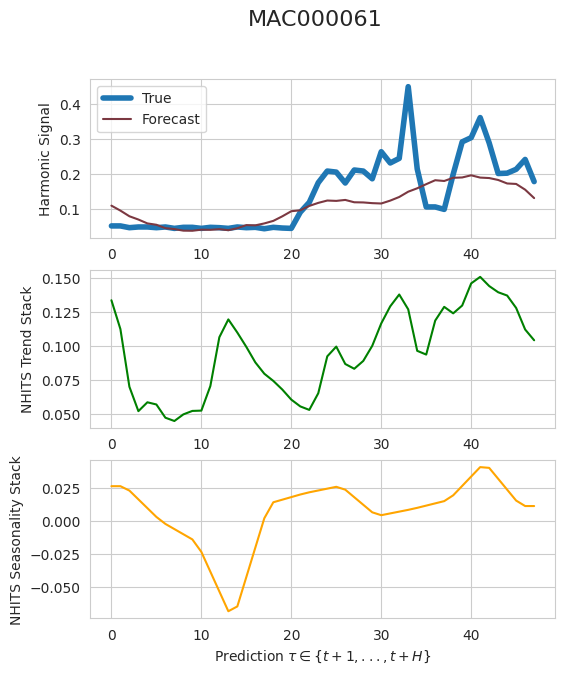

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

fig.suptitle(training_df.LCLid[0], fontsize=16)
ax[0].plot(validation_df[validation_df.LCLid == training_df.LCLid[0]]['energy_consumption'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,2]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NHITS Trend Stack')

ax[2].plot(y_hat[0,1], label='stack2', color="orange")
ax[2].set_ylabel('NHITS Seasonality Stack')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')

plt.show()
fig.savefig('imgs/chapter_16/NHITS_interp.png')

## TEST SET Predictions

In [28]:
h_test = len(test_df.timestamp.unique()) # horizon of the test set

if RETUNE == True:
    config = NHITS_best_config
else:
    config = loaded_config

models_test = [AutoNHITS(h=h_test, 
                    config = config,
                    search_alg = None,
                    backend = 'ray')]

models_test = NeuralForecast(models=models_test, freq='30min')
models_test.fit(train_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

(_train_tune pid=239447) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00000_0_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=23944

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00001_1_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00002_2_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 3.8 M     Trainable params
(_train_tune pid=239447) 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00003_3_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00004_4_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00005_5_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00006_6_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 3.8 M     Tra

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00007_7_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00008_8_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=239447) Seed set to 1
(_train_tune pid=239447) GPU available: False, used: False
(_train_tune pid=239447) TPU available: False, using: 0 TPU cores
(_train_tune pid=239447) IPU available: False, using: 0 IPUs
(_train_tune pid=239447) HPU available: False, using: 0 HPUs
(_train_tune pid=239447) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_17-24-33/_train_tune_bdb6f_00009_9_2024-08-12_17-24-33/lightning_logs
(_train_tune pid=239447) 
(_train_tune pid=239447)   | Name         | Type          | Params
(_train_tune pid=239447) -----------------------------------------------
(_train_tune pid=239447) 0 | loss         | MAE           | 0     
(_train_tune pid=239447) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=239447) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=239447) 3 | blocks       | ModuleList    | 3.8 M 
(_train_tune pid=239447) -------------

Epoch 19:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 4/5 [00:02<00:00,  1.39it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.090]


Seed set to 1


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.090]


(_train_tune pid=239447) `Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.8 M 
-----------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.297    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [29]:
pred_df_test =  models_test.predict(futr_df=test_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df_test = pred_df_test.merge(test_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df_test.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  AutoNHITS  energy_consumption
0  MAC000061 2014-01-01 00:00:00   0.143836               0.165
1  MAC000061 2014-01-01 00:30:00   0.135088               0.167
2  MAC000061 2014-01-01 01:00:00   0.105392               0.150
3  MAC000061 2014-01-01 01:30:00   0.084344               0.091
4  MAC000061 2014-01-01 02:00:00   0.072103               0.047

In [30]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
NHITS_metrics_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
NHITS_metrics_agg_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [31]:
NHITS_metrics_agg_test

metric  AutoNHITS
0   rmse   0.215125
1    mae   0.127892
2    mse   0.080651
3   mase   1.094118

In [32]:
NHITS_metrics_test.head()

LCLid metric  AutoNHITS
0  MAC000061   rmse   0.075132
1  MAC000062   rmse   0.186382
2  MAC000066   rmse   0.132023
3  MAC000086   rmse   0.155620
4  MAC000126   rmse   0.173153

In [35]:
NHITS_metrics_test

LCLid metric  AutoNHITS
0    MAC000061   rmse   0.075132
1    MAC000062   rmse   0.186382
2    MAC000066   rmse   0.132023
3    MAC000086   rmse   0.155620
4    MAC000126   rmse   0.173153
..         ...    ...        ...
595  MAC005336   mase   2.578367
596  MAC005375   mase   1.310019
597  MAC005463   mase   1.049463
598  MAC005521   mase   1.089539
599  MAC005529   mase   1.109253

[600 rows x 3 columns]

In [34]:
NHITS_metrics_agg_test.to_pickle(output/'NHITS_metrics_agg_test.pkl')
NHITS_metrics_test.to_pickle(output/'NHITS_metrics_test.pkl')